Hello there, I've been gone for a long time, but you know, not like it was noticable or anything. _**cries in Eigenvectors**_. Well, if you must know the reason for my being gone for such a long time then look no further than: work, school, work, sleep, anime, sleep and just being generally lazy, like everyone I know this period except way before the headstart. I don't have that much strength to go in depth about it so I WON'T. Anyhow, 2020?

Let's get to today's task: Forecasting confirmed COVID-19 cases. I would have to put it up on a 'Beginner's pedastal' so it should be super easy to follow. Also, the case focus would be my home country: Nigeria.

If you'd like to view a COVID-19 Dashboard, I made one a couple of weeks back for just African countries: [click here to view the dashboard](https://covid19-tracker-af.herokuapp.com)


Let's get to it!

In [1]:
#Import packages/tools 

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb #look at me not following norms.


import plotly.express as px #I like this one

from sklearn.preprocessing import StandardScaler

# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Parallel, Pipeline, FeatureUnion


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import NuSVR
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('error','ignore')

In [240]:
sb.set(style='white', font_scale=1.2, rc={"figure.figsize": (15,10)})


colors_ = {
    'background': '#111111',
    'text': '#BEBEBE',
    'grid': '#333333',
    'red': '#BF0000'
}

tickFont = {
    'size':12,
    'color':"rgb(30,30,30)",
    'family':"Courier New, monospace"}

SEED = 9
RANDOM_STATE = 5

In [241]:
from plotly.offline import init_notebook_mode,plot,iplot
import cufflinks
init_notebook_mode()
cufflinks.go_offline()

pd.set_option("max_rows", 500)



Next line: Data containing the cumulated confirmed cases(as well as Recovery and Deaths) daily, country and the data is loaded. I had to drop columns I won't be using such as Province/State, Cumulated Deaths and Recovery and the date is parsed as datetime.


Data Source: []('')

In [242]:
data = pd.read_csv("~/NG_covid19_ML/data/allData.csv")\
        .drop(["Province/State", "CumDeaths", "CumRecovered"], axis=1)\
        .astype({'date':'datetime64[ns]'})

data.head(3)

Country/Region       date  CumConfirmed
0    Afghanistan 2020-01-22             0
1        Albania 2020-01-22             0
2        Algeria 2020-01-22             0

In [243]:
#rename Country/Region to just Country
data.rename(columns={'Country/Region':'Country'}, inplace=True)

In [244]:
data.isna().sum() #No null values. Good!

Country         0
date            0
CumConfirmed    0
dtype: int64

Let's dedicate a couple of lines to making graphs: worldwide and then Africa.

In [245]:
countries_to_plot = ["US", "Italy", "China", "Germany", "Ghana", "Morocco", "Nigeria", "South Africa", "Tunisia"]
country_group = data.groupby(['date', 'Country'], as_index=False)['CumConfirmed'].sum()


xc = country_group[country_group["Country"].isin(countries_to_plot)]


trend_fig = px.line(xc, x="date", y="CumConfirmed", color="Country").for_each_trace\
(lambda rmvequalsign: rmvequalsign.update(name=rmvequalsign.name.split("=")[-1]))
trend_fig.update_traces(
        line=dict(width=3),
        selector=dict(type="scatter", mode="lines")
        )
trend_fig.update_layout({'legend_orientation':'h'}, font=tickFont)\
        .update_xaxes(title="", tickfont=tickFont)\
        .update_yaxes(title="Cumulated Confirmed Cases")
        
    
#african countries have lower cases so it's hard sighting them on the graph\
#(thousands compared to a million)

In [246]:
countries_to_plot = ["Ghana", "Morocco", "Nigeria", "South Africa", "Tunisia", "Kenya"] #6 african countries
country_group = data.groupby(['date', 'Country'], as_index=False)['CumConfirmed'].sum()


xc = country_group[country_group["Country"].isin(countries_to_plot)]


trend_fig = px.line(xc, x="date", y="CumConfirmed", color="Country").for_each_trace\
(lambda rmvequalsign: rmvequalsign.update(name=rmvequalsign.name.split("=")[-1]))
trend_fig.update_traces(
        line=dict(width=3),
        selector=dict(type="scatter", mode="lines")
        )
trend_fig.update_layout({'legend_orientation':'h'}, font=tickFont)\
        .update_xaxes(title="", tickfont=tickFont)\
        .update_yaxes(title="Cumulated Confirmed Cases")

iplot(trend_fig)

In [247]:
#I shall be extracting data for Nigeria only
NG_data = data[data["Country"] == "Nigeria"]
NG_data.reset_index(drop=True, inplace=True)

In [248]:
#peep into the data and check last accounted date
NG_data.tail()  #29th, April 2020

Country       date  CumConfirmed
94  Nigeria 2020-04-25          1182
95  Nigeria 2020-04-26          1273
96  Nigeria 2020-04-27          1337
97  Nigeria 2020-04-28          1532
98  Nigeria 2020-04-29          1728

Going through the data I noticed that the 20th and 21st of April had the same value of 665, which would indicate that there was no case on the 21st but there was. One of the highest cases ever recorded: 117. I checked the NCDC's site to confirm and made the required changes to that index. Also, the first case in Nigeria wasn't till the 28th of February so I had to tailor the data starting from the 27th of February, just to get rid of that long list of zeros.

Let's investigate together!

In [249]:
NG_data[NG_data["CumConfirmed"] > 0].head(12) #easily identify first case - 28th. 
#No further case until the 9th of March. Take note of the index (37, so tailor from 36)

Country       date  CumConfirmed
37  Nigeria 2020-02-28             1
38  Nigeria 2020-02-29             1
39  Nigeria 2020-03-01             1
40  Nigeria 2020-03-02             1
41  Nigeria 2020-03-03             1
42  Nigeria 2020-03-04             1
43  Nigeria 2020-03-05             1
44  Nigeria 2020-03-06             1
45  Nigeria 2020-03-07             1
46  Nigeria 2020-03-08             1
47  Nigeria 2020-03-09             2
48  Nigeria 2020-03-10             2

In [250]:
NG_data = NG_data.iloc[36:, :] #Tailored!
NG_data.reset_index(drop=True, inplace=True)
NG_data.head()

Country       date  CumConfirmed
0  Nigeria 2020-02-27             0
1  Nigeria 2020-02-28             1
2  Nigeria 2020-02-29             1
3  Nigeria 2020-03-01             1
4  Nigeria 2020-03-02             1

In [251]:
NG_data.tail(8) #note index 53 and 54

Country       date  CumConfirmed
55  Nigeria 2020-04-22           873
56  Nigeria 2020-04-23           981
57  Nigeria 2020-04-24          1095
58  Nigeria 2020-04-25          1182
59  Nigeria 2020-04-26          1273
60  Nigeria 2020-04-27          1337
61  Nigeria 2020-04-28          1532
62  Nigeria 2020-04-29          1728

In [252]:
NG_data.iplot(x='date', y='CumConfirmed')

Could you tell that flat curve just after 'Apr 19,' yeah? That's the culprit; 665 both on the 20th and 21st, while this could be a good thing meaning Nigeria had no new case on the 21st, we know that's false. In fact, we had 117 new cases on the 21st, summing it to 782. Hence, (20th) 665 - (21st) 782 - (22nd) 873 and so forth.


Also, NCDC's correction for the 18th of April: 541 instead of 542. Index 51.

Proof has been included below and update is to be made.


![21_04_2020]({static}/images/ncdc_21st.jpg)


In [253]:
#index 54, column CumConfirmed, replace 665 with 782
NG_data.at[54, 'CumConfirmed'] = 782 

NG_data.iloc[53:56, :] #perfection!

Country       date  CumConfirmed
53  Nigeria 2020-04-20           665
54  Nigeria 2020-04-21           782
55  Nigeria 2020-04-22           873

In [254]:
NG_data.at[51, 'CumConfirmed'] = 541
NG_data.iloc[50:52, :]

Country       date  CumConfirmed
50  Nigeria 2020-04-17           493
51  Nigeria 2020-04-18           541

In [255]:
#re-draw.
px.line(NG_data, x='date', y='CumConfirmed')

Now, let's use dataFrame.diff() on the CumConfirmed Column so we can get the daily cases from it, convert possible NaNs to zeros, which should be only one at the very top(0 - 'no value' = NaN)

In [256]:
NG_data["DailyConfirmed"] = NG_data["CumConfirmed"].diff()
NG_data.head()

Country       date  CumConfirmed  DailyConfirmed
0  Nigeria 2020-02-27             0             NaN
1  Nigeria 2020-02-28             1             1.0
2  Nigeria 2020-02-29             1             0.0
3  Nigeria 2020-03-01             1             0.0
4  Nigeria 2020-03-02             1             0.0

In [257]:
NG_data.fillna(axis=1, value=0, inplace=True)
NG_data.head(5)

Country       date  CumConfirmed  DailyConfirmed
0  Nigeria 2020-02-27             0             0.0
1  Nigeria 2020-02-28             1             1.0
2  Nigeria 2020-02-29             1             0.0
3  Nigeria 2020-03-01             1             0.0
4  Nigeria 2020-03-02             1             0.0

In [258]:
#cases on a daily basis
px.line(NG_data, x='date', y='DailyConfirmed')

Now, let's slip in data for our testing. I want to make predictions for the next 8 days, starting on the 28th, and then merge with our data on the row level.

In [1]:
post_date = ['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08']
post_incident = pd.DataFrame(post_date, columns=["date"])
post_incident["date"] = post_incident['date'].astype('datetime64[ns]')
post_incident.head(5)

NameError: name 'pd' is not defined

In [260]:
covid19_NG = pd.concat([NG_data, post_incident], sort=False, axis=0)
covid19_NG.reset_index(drop=True, inplace=True)
covid19_NG.tail(15)

Country       date  CumConfirmed  DailyConfirmed
56  Nigeria 2020-04-23         981.0           108.0
57  Nigeria 2020-04-24        1095.0           114.0
58  Nigeria 2020-04-25        1182.0            87.0
59  Nigeria 2020-04-26        1273.0            91.0
60  Nigeria 2020-04-27        1337.0            64.0
61  Nigeria 2020-04-28        1532.0           195.0
62  Nigeria 2020-04-29        1728.0           196.0
63      NaN 2020-04-30           NaN             NaN
64      NaN 2020-05-01           NaN             NaN
65      NaN 2020-05-02           NaN             NaN
66      NaN 2020-05-03           NaN             NaN
67      NaN 2020-05-04           NaN             NaN
68      NaN 2020-05-05           NaN             NaN
69      NaN 2020-05-06           NaN             NaN
70      NaN 2020-05-07           NaN             NaN

In [261]:
covid19_NG["day"] = covid19_NG.date.dt.strftime("%m%d").astype('int')

covid19_NG.head()

Country       date  CumConfirmed  DailyConfirmed  day
0  Nigeria 2020-02-27           0.0             0.0  227
1  Nigeria 2020-02-28           1.0             1.0  228
2  Nigeria 2020-02-29           1.0             0.0  229
3  Nigeria 2020-03-01           1.0             0.0  301
4  Nigeria 2020-03-02           1.0             0.0  302

I checked around for news that could be of value in terms of feature engineering.

##### 21-03-2020: NG bans entry of travelers from 13 countries(incl. US, Uk, Italy, France and China) [ng.usembassy.gov]  Ban to last for 4 weeks.
28-03-2020: GTB hands over 110-bed isolation centre to Lagos State Gov.
##### 08-04-2020: 110-bed isolation centre by GTB begins operation. [Allafrica]('https://allafrica.com']
##### 31-03-2020: Lockdown as announced by Pres. Buhari (Starts 11:30PM on the 30th, so next day then)
14-04-2020: Another lockdown starts. 
04-03-2020: No single isolation centre in Abuja says Senate President. [Punch.ng]
27-01-2020: First Nigeria case. [NCDC]('https://ncdc.gov.ng')
##### 21-02-2020: covid19 training starts ncdc.gov.ng

I contemplated using the bolded ones and ended up picking just one: Travel Ban. Lockdown started looking like Travel Ban after some days so I just dropped it.

In [262]:
def lk(val):
    if val >= 331 and val <= 404:
        return "Relaxed"
    elif val >= 405 and val <=414:
        return "Tight"
    elif val <= 330:
        return "Not enforced"
    else:
        return "Relaxed"

In [263]:
covid19_NG["Lockdown"] = covid19_NG["day"].apply(lk)
covid19_NG[covid19_NG["Lockdown"] == "Relaxed"].head(3)

Country       date  CumConfirmed  DailyConfirmed  day Lockdown
33  Nigeria 2020-03-31         135.0             4.0  331  Relaxed
34  Nigeria 2020-04-01         174.0            39.0  401  Relaxed
35  Nigeria 2020-04-02         184.0            10.0  402  Relaxed

In [264]:
covid19_NG["Travel Ban"] = covid19_NG["day"].apply(lambda x: "Enforced" if x >= 321 else "Not Enforced")
covid19_NG[covid19_NG["Travel Ban"] == "Enforced"].head(3)

#321 - 21st of March, when ban became effective.

Country       date  CumConfirmed  DailyConfirmed  day      Lockdown  \
23  Nigeria 2020-03-21          22.0            10.0  321  Not enforced   
24  Nigeria 2020-03-22          30.0             8.0  322  Not enforced   
25  Nigeria 2020-03-23          40.0            10.0  323  Not enforced   

   Travel Ban  
23   Enforced  
24   Enforced  
25   Enforced

In [265]:
covid19_NG["day_name"] = covid19_NG.date.dt.day_name()
covid19_NG.head()

Country       date  CumConfirmed  DailyConfirmed  day      Lockdown  \
0  Nigeria 2020-02-27           0.0             0.0  227  Not enforced   
1  Nigeria 2020-02-28           1.0             1.0  228  Not enforced   
2  Nigeria 2020-02-29           1.0             0.0  229  Not enforced   
3  Nigeria 2020-03-01           1.0             0.0  301  Not enforced   
4  Nigeria 2020-03-02           1.0             0.0  302  Not enforced   

     Travel Ban  day_name  
0  Not Enforced  Thursday  
1  Not Enforced    Friday  
2  Not Enforced  Saturday  
3  Not Enforced    Sunday  
4  Not Enforced    Monday

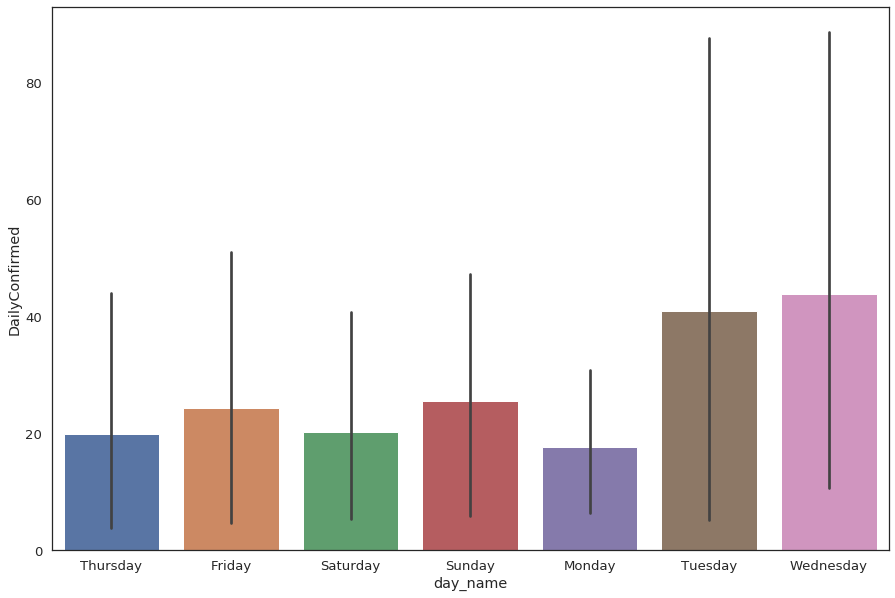

In [266]:
sb.barplot(data=covid19_NG, x="day_name", y="DailyConfirmed")

In [267]:
print("Highest reported cases in Nigeria: ", covid19_NG["DailyConfirmed"].max())
covid19_NG[covid19_NG["DailyConfirmed"] == covid19_NG["DailyConfirmed"].max()]

Highest reported cases in Nigeria:  196.0


Country       date  CumConfirmed  DailyConfirmed  day Lockdown Travel Ban  \
62  Nigeria 2020-04-29        1728.0           196.0  429  Relaxed   Enforced   

     day_name  
62  Wednesday

In [268]:
covid19_NG.drop(["Country", "date"], axis=1, inplace=True) #drop country and date

In [269]:
#Log transform DailyConfirmed. NaNs won't be transformed
covid19_NG["DailyConfirmed"] = np.log1p(covid19_NG["DailyConfirmed"])

In [270]:
covid19_NG = pd.get_dummies(covid19_NG, drop_first=True) #get dummies 
covid19_NG.head()

CumConfirmed  DailyConfirmed  day  Lockdown_Relaxed  Lockdown_Tight  \
0           0.0        0.000000  227                 0               0   
1           1.0        0.693147  228                 0               0   
2           1.0        0.000000  229                 0               0   
3           1.0        0.000000  301                 0               0   
4           1.0        0.000000  302                 0               0   

   Travel Ban_Not Enforced  day_name_Monday  day_name_Saturday  \
0                        1                0                  0   
1                        1                0                  0   
2                        1                0                  1   
3                        1                0                  0   
4                        1                1                  0   

   day_name_Sunday  day_name_Thursday  day_name_Tuesday  day_name_Wednesday  
0                0                  1                 0                   0  
1                0                  0                 0                   0  
2                0                  0                 0                   0  
3                1                  0                 0                   0  
4                0                  0                 0                   0

Let's split the data into train, validation and testing.


In [271]:
train = covid19_NG[covid19_NG["day"] <= 427] #Train on this
val = covid19_NG[(covid19_NG["day"] >= 428) & (covid19_NG["day"] <= 429)] #validate
test = covid19_NG[covid19_NG["day"] >= 430] #test

In [272]:
print("Original data shape: ", covid19_NG.shape, "\nTrain shape: ", train.shape, "\nValidation data shape", val.shape, "\nTest data shape: ",test.shape)

Original data shape:  (71, 12) 
Train shape:  (61, 12) 
Validation data shape (2, 12) 
Test data shape:  (8, 12)


Get ready for TRAINING and TESTING!
<!-- ({static}/images/GD-towardscience.png) -->
![fight!]({static}/gifs/hinata.gif "fight!")

In [273]:
Xtrain = train.drop(["CumConfirmed", "DailyConfirmed"], axis=1)
ytrain = train["DailyConfirmed"]

Xval = val.drop(["CumConfirmed", "DailyConfirmed"], axis=1)
yval = val["DailyConfirmed"]

Xtest = test.drop(["CumConfirmed", "DailyConfirmed"], axis=1)

Xtrain.head(3)

day  Lockdown_Relaxed  Lockdown_Tight  Travel Ban_Not Enforced  \
0  227                 0               0                        1   
1  228                 0               0                        1   
2  229                 0               0                        1   

   day_name_Monday  day_name_Saturday  day_name_Sunday  day_name_Thursday  \
0                0                  0                0                  1   
1                0                  0                0                  0   
2                0                  1                0                  0   

   day_name_Tuesday  day_name_Wednesday  
0                 0                   0  
1                 0                   0  
2                 0                   0

In [274]:
ss = StandardScaler()

In [275]:
Xtrain = ss.fit_transform(Xtrain)
Xval = ss.transform(Xval)
Xtest = ss.transform(Xtest)

In [276]:
from sklearn.metrics import mean_squared_error as mse

In [277]:

br = BayesianRidge(n_iter=1000)
gu = GaussianNB()

In [2]:
cat_params = {
    'num_boost_round':50000,
    'learning_rate': 0.001,
    'silent':True,
    'eval_metric': 'RMSE',
    'early_stopping_rounds':100,
    'max_depth':7,
    'use_best_model':True,
    'random_state': RANDOM_STATE
}


NameError: name 'RANDOM_STATE' is not defined

In [293]:
cat_model = CatBoostRegressor(**cat_params)
rf_model = RandomForestRegressor(n_estimators=80000, random_state=RANDOM_STATE)
nuSVR = NuSVR(C=100, cache_size=400, tol=0.005, gamma='auto', coef0=0.05)

#####################################

In [294]:
cat_model.fit(Xtrain, ytrain, eval_set=[(Xval, yval)])
print("Best Score: ", cat_model.best_score_, "\nIteration stopped at: ", cat_model.best_iteration_)

0:	learn: 2.6106075	test: 5.2792557	best: 5.2792557 (0)	total: 33.4ms	remaining: 27m 51s
1:	learn: 2.6086758	test: 5.2763467	best: 5.2763467 (1)	total: 34.9ms	remaining: 14m 33s
2:	learn: 2.6066843	test: 5.2731313	best: 5.2731313 (2)	total: 35.6ms	remaining: 9m 53s
3:	learn: 2.6048109	test: 5.2697079	best: 5.2697079 (3)	total: 37.5ms	remaining: 7m 49s
4:	learn: 2.6027647	test: 5.2665261	best: 5.2665261 (4)	total: 38.3ms	remaining: 6m 23s
5:	learn: 2.6005891	test: 5.2636300	best: 5.2636300 (5)	total: 39.1ms	remaining: 5m 25s
6:	learn: 2.5988388	test: 5.2610810	best: 5.2610810 (6)	total: 40.3ms	remaining: 4m 47s
7:	learn: 2.5971963	test: 5.2594704	best: 5.2594704 (7)	total: 42.3ms	remaining: 4m 24s
8:	learn: 2.5955971	test: 5.2573351	best: 5.2573351 (8)	total: 44.1ms	remaining: 4m 5s
9:	learn: 2.5934718	test: 5.2542940	best: 5.2542940 (9)	total: 45ms	remaining: 3m 44s
10:	learn: 2.5913075	test: 5.2514089	best: 5.2514089 (10)	total: 45.5ms	remaining: 3m 26s
11:	learn: 2.5892268	test: 5.24

177:	learn: 2.2986594	test: 4.8234578	best: 4.8234578 (177)	total: 215ms	remaining: 1m
178:	learn: 2.2971796	test: 4.8204642	best: 4.8204642 (178)	total: 218ms	remaining: 1m
179:	learn: 2.2955069	test: 4.8179235	best: 4.8179235 (179)	total: 219ms	remaining: 1m
180:	learn: 2.2938731	test: 4.8159578	best: 4.8159578 (180)	total: 220ms	remaining: 1m
181:	learn: 2.2922061	test: 4.8134213	best: 4.8134213 (181)	total: 221ms	remaining: 1m
182:	learn: 2.2908285	test: 4.8115659	best: 4.8115659 (182)	total: 223ms	remaining: 1m
183:	learn: 2.2889914	test: 4.8088529	best: 4.8088529 (183)	total: 223ms	remaining: 1m
184:	learn: 2.2873642	test: 4.8063033	best: 4.8063033 (184)	total: 224ms	remaining: 1m
185:	learn: 2.2858978	test: 4.8043702	best: 4.8043702 (185)	total: 225ms	remaining: 1m
186:	learn: 2.2840924	test: 4.8015608	best: 4.8015608 (186)	total: 226ms	remaining: 1m
187:	learn: 2.2824551	test: 4.7985292	best: 4.7985292 (187)	total: 227ms	remaining: 1m
188:	learn: 2.2807709	test: 4.7965755	best:

332:	learn: 2.0590762	test: 4.4701559	best: 4.4701559 (332)	total: 398ms	remaining: 59.3s
333:	learn: 2.0574481	test: 4.4678831	best: 4.4678831 (333)	total: 399ms	remaining: 59.3s
334:	learn: 2.0560586	test: 4.4657371	best: 4.4657371 (334)	total: 400ms	remaining: 59.4s
335:	learn: 2.0548992	test: 4.4639756	best: 4.4639756 (335)	total: 402ms	remaining: 59.5s
336:	learn: 2.0533611	test: 4.4612319	best: 4.4612319 (336)	total: 403ms	remaining: 59.5s
337:	learn: 2.0521319	test: 4.4601002	best: 4.4601002 (337)	total: 406ms	remaining: 59.6s
338:	learn: 2.0507620	test: 4.4577050	best: 4.4577050 (338)	total: 407ms	remaining: 59.6s
339:	learn: 2.0495850	test: 4.4567545	best: 4.4567545 (339)	total: 409ms	remaining: 59.8s
340:	learn: 2.0480930	test: 4.4540190	best: 4.4540190 (340)	total: 411ms	remaining: 59.9s
341:	learn: 2.0465478	test: 4.4515120	best: 4.4515120 (341)	total: 413ms	remaining: 59.9s
342:	learn: 2.0451726	test: 4.4490072	best: 4.4490072 (342)	total: 414ms	remaining: 59.9s
343:	learn

501:	learn: 1.8318075	test: 4.1333530	best: 4.1333530 (501)	total: 577ms	remaining: 56.9s
502:	learn: 1.8305133	test: 4.1320925	best: 4.1320925 (502)	total: 581ms	remaining: 57.1s
503:	learn: 1.8293912	test: 4.1312976	best: 4.1312976 (503)	total: 583ms	remaining: 57.3s
504:	learn: 1.8280831	test: 4.1292171	best: 4.1292171 (504)	total: 584ms	remaining: 57.2s
505:	learn: 1.8268941	test: 4.1274748	best: 4.1274748 (505)	total: 586ms	remaining: 57.3s
506:	learn: 1.8256665	test: 4.1257169	best: 4.1257169 (506)	total: 587ms	remaining: 57.3s
507:	learn: 1.8243119	test: 4.1235139	best: 4.1235139 (507)	total: 589ms	remaining: 57.4s
508:	learn: 1.8230605	test: 4.1219801	best: 4.1219801 (508)	total: 590ms	remaining: 57.4s
509:	learn: 1.8217874	test: 4.1200034	best: 4.1200034 (509)	total: 592ms	remaining: 57.4s
510:	learn: 1.8204908	test: 4.1178517	best: 4.1178517 (510)	total: 592ms	remaining: 57.4s
511:	learn: 1.8191116	test: 4.1156416	best: 4.1156416 (511)	total: 593ms	remaining: 57.3s
512:	learn

629:	learn: 1.6781178	test: 3.8998914	best: 3.8998914 (629)	total: 762ms	remaining: 59.7s
630:	learn: 1.6768961	test: 3.8981072	best: 3.8981072 (630)	total: 766ms	remaining: 59.9s
631:	learn: 1.6758699	test: 3.8974207	best: 3.8974207 (631)	total: 768ms	remaining: 60s
632:	learn: 1.6746613	test: 3.8955752	best: 3.8955752 (632)	total: 769ms	remaining: 60s
633:	learn: 1.6733805	test: 3.8937914	best: 3.8937914 (633)	total: 769ms	remaining: 59.9s
634:	learn: 1.6723501	test: 3.8916901	best: 3.8916901 (634)	total: 770ms	remaining: 59.9s
635:	learn: 1.6712353	test: 3.8902960	best: 3.8902960 (635)	total: 772ms	remaining: 59.9s
636:	learn: 1.6701685	test: 3.8880686	best: 3.8880686 (636)	total: 774ms	remaining: 1m
637:	learn: 1.6689729	test: 3.8860531	best: 3.8860531 (637)	total: 776ms	remaining: 1m
638:	learn: 1.6677715	test: 3.8843114	best: 3.8843114 (638)	total: 777ms	remaining: 60s
639:	learn: 1.6666373	test: 3.8825209	best: 3.8825209 (639)	total: 780ms	remaining: 1m
640:	learn: 1.6655871	tes

781:	learn: 1.5156023	test: 3.6498240	best: 3.6498240 (781)	total: 945ms	remaining: 59.5s
782:	learn: 1.5145663	test: 3.6481182	best: 3.6481182 (782)	total: 946ms	remaining: 59.5s
783:	learn: 1.5136312	test: 3.6464071	best: 3.6464071 (783)	total: 948ms	remaining: 59.5s
784:	learn: 1.5126676	test: 3.6457840	best: 3.6457840 (784)	total: 950ms	remaining: 59.6s
785:	learn: 1.5116937	test: 3.6441784	best: 3.6441784 (785)	total: 951ms	remaining: 59.6s
786:	learn: 1.5107968	test: 3.6422375	best: 3.6422375 (786)	total: 952ms	remaining: 59.6s
787:	learn: 1.5096944	test: 3.6404316	best: 3.6404316 (787)	total: 954ms	remaining: 59.6s
788:	learn: 1.5089764	test: 3.6394695	best: 3.6394695 (788)	total: 956ms	remaining: 59.7s
789:	learn: 1.5079102	test: 3.6378418	best: 3.6378418 (789)	total: 957ms	remaining: 59.6s
790:	learn: 1.5068248	test: 3.6360396	best: 3.6360396 (790)	total: 958ms	remaining: 59.6s
791:	learn: 1.5059350	test: 3.6346695	best: 3.6346695 (791)	total: 960ms	remaining: 59.6s
792:	learn

933:	learn: 1.3752272	test: 3.4298186	best: 3.4298186 (933)	total: 1.13s	remaining: 59.1s
934:	learn: 1.3743389	test: 3.4286971	best: 3.4286971 (934)	total: 1.13s	remaining: 59.1s
935:	learn: 1.3735301	test: 3.4274306	best: 3.4274306 (935)	total: 1.13s	remaining: 59.1s
936:	learn: 1.3726201	test: 3.4256985	best: 3.4256985 (936)	total: 1.13s	remaining: 59.2s
937:	learn: 1.3718074	test: 3.4244158	best: 3.4244158 (937)	total: 1.13s	remaining: 59.2s
938:	learn: 1.3710564	test: 3.4231333	best: 3.4231333 (938)	total: 1.13s	remaining: 59.2s
939:	learn: 1.3702541	test: 3.4212875	best: 3.4212875 (939)	total: 1.14s	remaining: 59.3s
940:	learn: 1.3692699	test: 3.4198797	best: 3.4198797 (940)	total: 1.14s	remaining: 59.3s
941:	learn: 1.3683162	test: 3.4180301	best: 3.4180301 (941)	total: 1.14s	remaining: 59.3s
942:	learn: 1.3674283	test: 3.4164145	best: 3.4164145 (942)	total: 1.14s	remaining: 59.3s
943:	learn: 1.3665163	test: 3.4151902	best: 3.4151902 (943)	total: 1.14s	remaining: 59.3s
944:	learn

1092:	learn: 1.2456791	test: 3.2156423	best: 3.2156423 (1092)	total: 1.31s	remaining: 58.5s
1093:	learn: 1.2450092	test: 3.2142301	best: 3.2142301 (1093)	total: 1.31s	remaining: 58.5s
1094:	learn: 1.2441479	test: 3.2127690	best: 3.2127690 (1094)	total: 1.31s	remaining: 58.5s
1095:	learn: 1.2434665	test: 3.2111689	best: 3.2111689 (1095)	total: 1.31s	remaining: 58.5s
1096:	learn: 1.2427114	test: 3.2102567	best: 3.2102567 (1096)	total: 1.31s	remaining: 58.5s
1097:	learn: 1.2420312	test: 3.2091963	best: 3.2091963 (1097)	total: 1.31s	remaining: 58.6s
1098:	learn: 1.2412759	test: 3.2079294	best: 3.2079294 (1098)	total: 1.31s	remaining: 58.5s
1099:	learn: 1.2406276	test: 3.2068040	best: 3.2068040 (1099)	total: 1.32s	remaining: 58.6s
1100:	learn: 1.2400404	test: 3.2062397	best: 3.2062397 (1100)	total: 1.32s	remaining: 58.6s
1101:	learn: 1.2392033	test: 3.2045676	best: 3.2045676 (1101)	total: 1.32s	remaining: 58.6s
1102:	learn: 1.2384526	test: 3.2033789	best: 3.2033789 (1102)	total: 1.32s	remai

1249:	learn: 1.1335186	test: 3.0270126	best: 3.0270126 (1249)	total: 1.49s	remaining: 58.1s
1250:	learn: 1.1329822	test: 3.0259593	best: 3.0259593 (1250)	total: 1.49s	remaining: 58.1s
1251:	learn: 1.1322820	test: 3.0248090	best: 3.0248090 (1251)	total: 1.49s	remaining: 58.1s
1252:	learn: 1.1316189	test: 3.0235508	best: 3.0235508 (1252)	total: 1.49s	remaining: 58.1s
1253:	learn: 1.1309211	test: 3.0226708	best: 3.0226708 (1253)	total: 1.49s	remaining: 58.1s
1254:	learn: 1.1302231	test: 3.0215234	best: 3.0215234 (1254)	total: 1.5s	remaining: 58.1s
1255:	learn: 1.1295711	test: 3.0205837	best: 3.0205837 (1255)	total: 1.5s	remaining: 58.1s
1256:	learn: 1.1289062	test: 3.0193832	best: 3.0193832 (1256)	total: 1.5s	remaining: 58.1s
1257:	learn: 1.1283185	test: 3.0183702	best: 3.0183702 (1257)	total: 1.5s	remaining: 58.1s
1258:	learn: 1.1275923	test: 3.0172692	best: 3.0172692 (1258)	total: 1.5s	remaining: 58s
1259:	learn: 1.1270156	test: 3.0162485	best: 3.0162485 (1259)	total: 1.5s	remaining: 58

1408:	learn: 1.0360530	test: 2.8603871	best: 2.8603871 (1408)	total: 1.67s	remaining: 57.6s
1409:	learn: 1.0354270	test: 2.8594055	best: 2.8594055 (1409)	total: 1.67s	remaining: 57.6s
1410:	learn: 1.0348015	test: 2.8582518	best: 2.8582518 (1410)	total: 1.67s	remaining: 57.6s
1411:	learn: 1.0341573	test: 2.8570990	best: 2.8570990 (1411)	total: 1.67s	remaining: 57.6s
1412:	learn: 1.0336310	test: 2.8561429	best: 2.8561429 (1412)	total: 1.68s	remaining: 57.6s
1413:	learn: 1.0330512	test: 2.8550727	best: 2.8550727 (1413)	total: 1.68s	remaining: 57.7s
1414:	learn: 1.0324026	test: 2.8536941	best: 2.8536941 (1414)	total: 1.68s	remaining: 57.7s
1415:	learn: 1.0318437	test: 2.8525130	best: 2.8525130 (1415)	total: 1.68s	remaining: 57.6s
1416:	learn: 1.0312826	test: 2.8511839	best: 2.8511839 (1416)	total: 1.68s	remaining: 57.7s
1417:	learn: 1.0306549	test: 2.8500749	best: 2.8500749 (1417)	total: 1.68s	remaining: 57.7s
1418:	learn: 1.0300873	test: 2.8493388	best: 2.8493388 (1418)	total: 1.68s	remai

1559:	learn: 0.9545425	test: 2.7095860	best: 2.7095860 (1559)	total: 1.85s	remaining: 57.4s
1560:	learn: 0.9540415	test: 2.7088911	best: 2.7088911 (1560)	total: 1.85s	remaining: 57.5s
1561:	learn: 0.9535163	test: 2.7081112	best: 2.7081112 (1561)	total: 1.85s	remaining: 57.5s
1562:	learn: 0.9530181	test: 2.7074174	best: 2.7074174 (1562)	total: 1.85s	remaining: 57.5s
1563:	learn: 0.9525725	test: 2.7062258	best: 2.7062258 (1563)	total: 1.86s	remaining: 57.5s
1564:	learn: 0.9520596	test: 2.7053595	best: 2.7053595 (1564)	total: 1.86s	remaining: 57.5s
1565:	learn: 0.9515832	test: 2.7045353	best: 2.7045353 (1565)	total: 1.86s	remaining: 57.5s
1566:	learn: 0.9511039	test: 2.7033191	best: 2.7033191 (1566)	total: 1.86s	remaining: 57.5s
1567:	learn: 0.9507257	test: 2.7025509	best: 2.7025509 (1567)	total: 1.86s	remaining: 57.6s
1568:	learn: 0.9502182	test: 2.7017780	best: 2.7017780 (1568)	total: 1.86s	remaining: 57.6s
1569:	learn: 0.9496954	test: 2.7005235	best: 2.7005235 (1569)	total: 1.86s	remai

1717:	learn: 0.8806819	test: 2.5725690	best: 2.5725690 (1717)	total: 2.03s	remaining: 57s
1718:	learn: 0.8802263	test: 2.5717968	best: 2.5717968 (1718)	total: 2.03s	remaining: 57s
1719:	learn: 0.8798147	test: 2.5710064	best: 2.5710064 (1719)	total: 2.03s	remaining: 57s
1720:	learn: 0.8793924	test: 2.5700900	best: 2.5700900 (1720)	total: 2.03s	remaining: 57s
1721:	learn: 0.8788873	test: 2.5688999	best: 2.5688999 (1721)	total: 2.03s	remaining: 57s
1722:	learn: 0.8784526	test: 2.5681410	best: 2.5681410 (1722)	total: 2.03s	remaining: 57s
1723:	learn: 0.8780034	test: 2.5672221	best: 2.5672221 (1723)	total: 2.04s	remaining: 57s
1724:	learn: 0.8775267	test: 2.5663038	best: 2.5663038 (1724)	total: 2.04s	remaining: 57s
1725:	learn: 0.8770749	test: 2.5655362	best: 2.5655362 (1725)	total: 2.04s	remaining: 57s
1726:	learn: 0.8767207	test: 2.5649976	best: 2.5649976 (1726)	total: 2.04s	remaining: 57s
1727:	learn: 0.8763088	test: 2.5642522	best: 2.5642522 (1727)	total: 2.04s	remaining: 57s
1728:	lear

1873:	learn: 0.8182213	test: 2.4501687	best: 2.4501687 (1873)	total: 2.21s	remaining: 56.8s
1874:	learn: 0.8178875	test: 2.4495207	best: 2.4495207 (1874)	total: 2.21s	remaining: 56.8s
1875:	learn: 0.8175025	test: 2.4488376	best: 2.4488376 (1875)	total: 2.21s	remaining: 56.8s
1876:	learn: 0.8171839	test: 2.4481690	best: 2.4481690 (1876)	total: 2.22s	remaining: 56.9s
1877:	learn: 0.8168179	test: 2.4475544	best: 2.4475544 (1877)	total: 2.22s	remaining: 56.9s
1878:	learn: 0.8164355	test: 2.4468730	best: 2.4468730 (1878)	total: 2.22s	remaining: 56.9s
1879:	learn: 0.8160536	test: 2.4461923	best: 2.4461923 (1879)	total: 2.22s	remaining: 56.9s
1880:	learn: 0.8156765	test: 2.4453737	best: 2.4453737 (1880)	total: 2.22s	remaining: 56.9s
1881:	learn: 0.8153219	test: 2.4444927	best: 2.4444927 (1881)	total: 2.23s	remaining: 56.9s
1882:	learn: 0.8149390	test: 2.4436730	best: 2.4436730 (1882)	total: 2.23s	remaining: 56.9s
1883:	learn: 0.8145904	test: 2.4431443	best: 2.4431443 (1883)	total: 2.23s	remai

2026:	learn: 0.7653399	test: 2.3424001	best: 2.3424001 (2026)	total: 2.39s	remaining: 56.6s
2027:	learn: 0.7650387	test: 2.3421073	best: 2.3421073 (2027)	total: 2.39s	remaining: 56.6s
2028:	learn: 0.7646949	test: 2.3412508	best: 2.3412508 (2028)	total: 2.4s	remaining: 56.6s
2029:	learn: 0.7642751	test: 2.3402927	best: 2.3402927 (2029)	total: 2.4s	remaining: 56.6s
2030:	learn: 0.7639794	test: 2.3394902	best: 2.3394902 (2030)	total: 2.4s	remaining: 56.6s
2031:	learn: 0.7636690	test: 2.3388887	best: 2.3388887 (2031)	total: 2.4s	remaining: 56.6s
2032:	learn: 0.7633482	test: 2.3382852	best: 2.3382852 (2032)	total: 2.4s	remaining: 56.6s
2033:	learn: 0.7630595	test: 2.3375498	best: 2.3375498 (2033)	total: 2.4s	remaining: 56.6s
2034:	learn: 0.7627376	test: 2.3367505	best: 2.3367505 (2034)	total: 2.4s	remaining: 56.6s
2035:	learn: 0.7623856	test: 2.3360702	best: 2.3360702 (2035)	total: 2.4s	remaining: 56.6s
2036:	learn: 0.7620761	test: 2.3355994	best: 2.3355994 (2036)	total: 2.4s	remaining: 56.

2160:	learn: 0.7249148	test: 2.2550858	best: 2.2550858 (2160)	total: 2.57s	remaining: 56.9s
2161:	learn: 0.7246059	test: 2.2542589	best: 2.2542589 (2161)	total: 2.57s	remaining: 56.9s
2162:	learn: 0.7243240	test: 2.2537103	best: 2.2537103 (2162)	total: 2.58s	remaining: 57s
2163:	learn: 0.7239962	test: 2.2528124	best: 2.2528124 (2163)	total: 2.58s	remaining: 57s
2164:	learn: 0.7236376	test: 2.2519134	best: 2.2519134 (2164)	total: 2.58s	remaining: 57s
2165:	learn: 0.7233565	test: 2.2512438	best: 2.2512438 (2165)	total: 2.58s	remaining: 57s
2166:	learn: 0.7230865	test: 2.2505333	best: 2.2505333 (2166)	total: 2.58s	remaining: 57s
2167:	learn: 0.7227444	test: 2.2495778	best: 2.2495778 (2167)	total: 2.58s	remaining: 56.9s
2168:	learn: 0.7224488	test: 2.2487946	best: 2.2487946 (2168)	total: 2.58s	remaining: 57s
2169:	learn: 0.7221616	test: 2.2481833	best: 2.2481833 (2169)	total: 2.58s	remaining: 56.9s
2170:	learn: 0.7218781	test: 2.2473822	best: 2.2473822 (2170)	total: 2.59s	remaining: 57s
21

2316:	learn: 0.6840522	test: 2.1623258	best: 2.1623258 (2316)	total: 2.75s	remaining: 56.7s
2317:	learn: 0.6838165	test: 2.1619760	best: 2.1619760 (2317)	total: 2.76s	remaining: 56.7s
2318:	learn: 0.6834925	test: 2.1611117	best: 2.1611117 (2318)	total: 2.76s	remaining: 56.7s
2319:	learn: 0.6832733	test: 2.1607782	best: 2.1607782 (2319)	total: 2.76s	remaining: 56.7s
2320:	learn: 0.6830261	test: 2.1602953	best: 2.1602953 (2320)	total: 2.76s	remaining: 56.7s
2321:	learn: 0.6828261	test: 2.1598698	best: 2.1598698 (2321)	total: 2.76s	remaining: 56.7s
2322:	learn: 0.6825273	test: 2.1590071	best: 2.1590071 (2322)	total: 2.76s	remaining: 56.7s
2323:	learn: 0.6823023	test: 2.1584087	best: 2.1584087 (2323)	total: 2.77s	remaining: 56.7s
2324:	learn: 0.6820768	test: 2.1577681	best: 2.1577681 (2324)	total: 2.77s	remaining: 56.7s
2325:	learn: 0.6818336	test: 2.1570872	best: 2.1570872 (2325)	total: 2.77s	remaining: 56.7s
2326:	learn: 0.6815479	test: 2.1562047	best: 2.1562047 (2326)	total: 2.77s	remai

2457:	learn: 0.6528710	test: 2.0881340	best: 2.0881340 (2457)	total: 2.94s	remaining: 56.8s
2458:	learn: 0.6526770	test: 2.0877000	best: 2.0877000 (2458)	total: 2.94s	remaining: 56.8s
2459:	learn: 0.6524805	test: 2.0873634	best: 2.0873634 (2459)	total: 2.94s	remaining: 56.8s
2460:	learn: 0.6523034	test: 2.0871609	best: 2.0871609 (2460)	total: 2.94s	remaining: 56.8s
2461:	learn: 0.6521190	test: 2.0867413	best: 2.0867413 (2461)	total: 2.94s	remaining: 56.9s
2462:	learn: 0.6519233	test: 2.0861991	best: 2.0861991 (2462)	total: 2.94s	remaining: 56.9s
2463:	learn: 0.6516949	test: 2.0857043	best: 2.0857043 (2463)	total: 2.95s	remaining: 56.9s
2464:	learn: 0.6515081	test: 2.0852646	best: 2.0852646 (2464)	total: 2.95s	remaining: 56.9s
2465:	learn: 0.6513101	test: 2.0847341	best: 2.0847341 (2465)	total: 2.95s	remaining: 56.9s
2466:	learn: 0.6511163	test: 2.0843083	best: 2.0843083 (2466)	total: 2.95s	remaining: 56.9s
2467:	learn: 0.6509917	test: 2.0840814	best: 2.0840814 (2467)	total: 2.95s	remai

2598:	learn: 0.6262779	test: 2.0210387	best: 2.0210387 (2598)	total: 3.12s	remaining: 56.8s
2599:	learn: 0.6261226	test: 2.0206723	best: 2.0206723 (2599)	total: 3.12s	remaining: 56.8s
2600:	learn: 0.6260155	test: 2.0204070	best: 2.0204070 (2600)	total: 3.12s	remaining: 56.8s
2601:	learn: 0.6258302	test: 2.0198230	best: 2.0198230 (2601)	total: 3.12s	remaining: 56.8s
2602:	learn: 0.6256649	test: 2.0194347	best: 2.0194347 (2602)	total: 3.12s	remaining: 56.8s
2603:	learn: 0.6254462	test: 2.0188449	best: 2.0188449 (2603)	total: 3.12s	remaining: 56.8s
2604:	learn: 0.6251935	test: 2.0181468	best: 2.0181468 (2604)	total: 3.12s	remaining: 56.8s
2605:	learn: 0.6250366	test: 2.0178606	best: 2.0178606 (2605)	total: 3.13s	remaining: 56.8s
2606:	learn: 0.6248806	test: 2.0174799	best: 2.0174799 (2606)	total: 3.13s	remaining: 56.8s
2607:	learn: 0.6246740	test: 2.0167010	best: 2.0167010 (2607)	total: 3.13s	remaining: 56.9s
2608:	learn: 0.6244472	test: 2.0160105	best: 2.0160105 (2608)	total: 3.13s	remai

2750:	learn: 0.6009864	test: 1.9538621	best: 1.9538621 (2750)	total: 3.3s	remaining: 56.6s
2751:	learn: 0.6008547	test: 1.9534901	best: 1.9534901 (2751)	total: 3.3s	remaining: 56.6s
2752:	learn: 0.6006618	test: 1.9528955	best: 1.9528955 (2752)	total: 3.3s	remaining: 56.7s
2753:	learn: 0.6005353	test: 1.9525538	best: 1.9525538 (2753)	total: 3.3s	remaining: 56.7s
2754:	learn: 0.6004015	test: 1.9523487	best: 1.9523487 (2754)	total: 3.3s	remaining: 56.7s
2755:	learn: 0.6002685	test: 1.9520042	best: 1.9520042 (2755)	total: 3.31s	remaining: 56.7s
2756:	learn: 0.6001387	test: 1.9515703	best: 1.9515703 (2756)	total: 3.31s	remaining: 56.7s
2757:	learn: 0.5999564	test: 1.9510372	best: 1.9510372 (2757)	total: 3.31s	remaining: 56.7s
2758:	learn: 0.5998240	test: 1.9506935	best: 1.9506935 (2758)	total: 3.31s	remaining: 56.7s
2759:	learn: 0.5996624	test: 1.9502053	best: 1.9502053 (2759)	total: 3.31s	remaining: 56.7s
2760:	learn: 0.5994493	test: 1.9495934	best: 1.9495934 (2760)	total: 3.31s	remaining:

2901:	learn: 0.5794016	test: 1.8922360	best: 1.8922360 (2901)	total: 3.48s	remaining: 56.5s
2902:	learn: 0.5792213	test: 1.8916092	best: 1.8916092 (2902)	total: 3.48s	remaining: 56.5s
2903:	learn: 0.5791120	test: 1.8913023	best: 1.8913023 (2903)	total: 3.48s	remaining: 56.5s
2904:	learn: 0.5789322	test: 1.8906079	best: 1.8906079 (2904)	total: 3.49s	remaining: 56.5s
2905:	learn: 0.5787555	test: 1.8900110	best: 1.8900110 (2905)	total: 3.49s	remaining: 56.5s
2906:	learn: 0.5785851	test: 1.8894147	best: 1.8894147 (2906)	total: 3.49s	remaining: 56.5s
2907:	learn: 0.5784600	test: 1.8890181	best: 1.8890181 (2907)	total: 3.49s	remaining: 56.5s
2908:	learn: 0.5782904	test: 1.8883757	best: 1.8883757 (2908)	total: 3.49s	remaining: 56.5s
2909:	learn: 0.5781097	test: 1.8878302	best: 1.8878302 (2909)	total: 3.49s	remaining: 56.5s
2910:	learn: 0.5780003	test: 1.8875251	best: 1.8875251 (2910)	total: 3.49s	remaining: 56.5s
2911:	learn: 0.5778857	test: 1.8871879	best: 1.8871879 (2911)	total: 3.5s	remain

3046:	learn: 0.5614058	test: 1.8386238	best: 1.8386238 (3046)	total: 3.66s	remaining: 56.5s
3047:	learn: 0.5613155	test: 1.8383494	best: 1.8383494 (3047)	total: 3.67s	remaining: 56.5s
3048:	learn: 0.5612260	test: 1.8380307	best: 1.8380307 (3048)	total: 3.67s	remaining: 56.5s
3049:	learn: 0.5610754	test: 1.8375807	best: 1.8375807 (3049)	total: 3.67s	remaining: 56.5s
3050:	learn: 0.5609861	test: 1.8372828	best: 1.8372828 (3050)	total: 3.67s	remaining: 56.5s
3051:	learn: 0.5609016	test: 1.8370073	best: 1.8370073 (3051)	total: 3.67s	remaining: 56.5s
3052:	learn: 0.5608455	test: 1.8368351	best: 1.8368351 (3052)	total: 3.67s	remaining: 56.5s
3053:	learn: 0.5607023	test: 1.8364372	best: 1.8364372 (3053)	total: 3.67s	remaining: 56.5s
3054:	learn: 0.5605369	test: 1.8358836	best: 1.8358836 (3054)	total: 3.68s	remaining: 56.5s
3055:	learn: 0.5604118	test: 1.8355268	best: 1.8355268 (3055)	total: 3.68s	remaining: 56.5s
3056:	learn: 0.5603196	test: 1.8351746	best: 1.8351746 (3056)	total: 3.68s	remai

3207:	learn: 0.5449438	test: 1.7832381	best: 1.7832381 (3207)	total: 3.84s	remaining: 56.1s
3208:	learn: 0.5448181	test: 1.7827088	best: 1.7827088 (3208)	total: 3.85s	remaining: 56.1s
3209:	learn: 0.5447289	test: 1.7827088	best: 1.7827088 (3208)	total: 3.85s	remaining: 56.1s
3210:	learn: 0.5446470	test: 1.7824671	best: 1.7824671 (3210)	total: 3.85s	remaining: 56.1s
3211:	learn: 0.5445077	test: 1.7818619	best: 1.7818619 (3211)	total: 3.85s	remaining: 56.1s
3212:	learn: 0.5444387	test: 1.7816857	best: 1.7816857 (3212)	total: 3.85s	remaining: 56.1s
3213:	learn: 0.5443064	test: 1.7813135	best: 1.7813135 (3213)	total: 3.85s	remaining: 56.1s
3214:	learn: 0.5442384	test: 1.7810911	best: 1.7810911 (3214)	total: 3.86s	remaining: 56.1s
3215:	learn: 0.5441495	test: 1.7807864	best: 1.7807864 (3215)	total: 3.86s	remaining: 56.1s
3216:	learn: 0.5440605	test: 1.7805125	best: 1.7805125 (3216)	total: 3.86s	remaining: 56.1s
3217:	learn: 0.5439365	test: 1.7800053	best: 1.7800053 (3217)	total: 3.86s	remai

3359:	learn: 0.5310409	test: 1.7355117	best: 1.7355117 (3359)	total: 4.02s	remaining: 55.9s
3360:	learn: 0.5309778	test: 1.7352769	best: 1.7352769 (3360)	total: 4.03s	remaining: 55.9s
3361:	learn: 0.5308392	test: 1.7347062	best: 1.7347062 (3361)	total: 4.03s	remaining: 55.9s
3362:	learn: 0.5307744	test: 1.7344915	best: 1.7344915 (3362)	total: 4.03s	remaining: 55.9s
3363:	learn: 0.5307161	test: 1.7342771	best: 1.7342771 (3363)	total: 4.03s	remaining: 55.9s
3364:	learn: 0.5306579	test: 1.7340629	best: 1.7340629 (3364)	total: 4.03s	remaining: 55.9s
3365:	learn: 0.5305884	test: 1.7337756	best: 1.7337756 (3365)	total: 4.03s	remaining: 55.9s
3366:	learn: 0.5304774	test: 1.7333223	best: 1.7333223 (3366)	total: 4.03s	remaining: 55.9s
3367:	learn: 0.5303631	test: 1.7329187	best: 1.7329187 (3367)	total: 4.04s	remaining: 55.9s
3368:	learn: 0.5302737	test: 1.7327484	best: 1.7327484 (3368)	total: 4.04s	remaining: 55.9s
3369:	learn: 0.5302041	test: 1.7325627	best: 1.7325627 (3369)	total: 4.04s	remai

3524:	learn: 0.5176008	test: 1.6852986	best: 1.6852986 (3524)	total: 4.21s	remaining: 55.5s
3525:	learn: 0.5174851	test: 1.6848696	best: 1.6848696 (3525)	total: 4.21s	remaining: 55.5s
3526:	learn: 0.5174410	test: 1.6846795	best: 1.6846795 (3526)	total: 4.21s	remaining: 55.5s
3527:	learn: 0.5173950	test: 1.6844915	best: 1.6844915 (3527)	total: 4.21s	remaining: 55.5s
3528:	learn: 0.5173507	test: 1.6842376	best: 1.6842376 (3528)	total: 4.21s	remaining: 55.5s
3529:	learn: 0.5172873	test: 1.6840887	best: 1.6840887 (3529)	total: 4.21s	remaining: 55.4s
3530:	learn: 0.5171735	test: 1.6837077	best: 1.6837077 (3530)	total: 4.22s	remaining: 55.5s
3531:	learn: 0.5171277	test: 1.6835201	best: 1.6835201 (3531)	total: 4.22s	remaining: 55.5s
3532:	learn: 0.5170726	test: 1.6833381	best: 1.6833381 (3532)	total: 4.22s	remaining: 55.5s
3533:	learn: 0.5169554	test: 1.6828965	best: 1.6828965 (3533)	total: 4.22s	remaining: 55.5s
3534:	learn: 0.5168962	test: 1.6827010	best: 1.6827010 (3534)	total: 4.22s	remai

3698:	learn: 0.5055470	test: 1.6380605	best: 1.6380605 (3698)	total: 4.39s	remaining: 54.9s
3699:	learn: 0.5055125	test: 1.6378965	best: 1.6378965 (3699)	total: 4.39s	remaining: 54.9s
3700:	learn: 0.5054748	test: 1.6377587	best: 1.6377587 (3700)	total: 4.39s	remaining: 54.9s
3701:	learn: 0.5054354	test: 1.6376311	best: 1.6376311 (3701)	total: 4.39s	remaining: 54.9s
3702:	learn: 0.5053997	test: 1.6374651	best: 1.6374651 (3702)	total: 4.39s	remaining: 54.9s
3703:	learn: 0.5053173	test: 1.6372842	best: 1.6372842 (3703)	total: 4.39s	remaining: 54.9s
3704:	learn: 0.5052800	test: 1.6371207	best: 1.6371207 (3704)	total: 4.39s	remaining: 54.9s
3705:	learn: 0.5052452	test: 1.6370068	best: 1.6370068 (3705)	total: 4.4s	remaining: 54.9s
3706:	learn: 0.5052100	test: 1.6368883	best: 1.6368883 (3706)	total: 4.4s	remaining: 54.9s
3707:	learn: 0.5051175	test: 1.6366426	best: 1.6366426 (3707)	total: 4.4s	remaining: 54.9s
3708:	learn: 0.5050078	test: 1.6361370	best: 1.6361370 (3708)	total: 4.4s	remaining

3852:	learn: 0.4962560	test: 1.6001917	best: 1.6001917 (3852)	total: 4.57s	remaining: 54.7s
3853:	learn: 0.4962269	test: 1.6000904	best: 1.6000904 (3853)	total: 4.57s	remaining: 54.7s
3854:	learn: 0.4961984	test: 1.5999452	best: 1.5999452 (3854)	total: 4.57s	remaining: 54.7s
3855:	learn: 0.4961610	test: 1.5998002	best: 1.5998002 (3855)	total: 4.57s	remaining: 54.7s
3856:	learn: 0.4961329	test: 1.5996716	best: 1.5996716 (3856)	total: 4.57s	remaining: 54.7s
3857:	learn: 0.4960897	test: 1.5995679	best: 1.5995679 (3857)	total: 4.57s	remaining: 54.7s
3858:	learn: 0.4960360	test: 1.5991425	best: 1.5991425 (3858)	total: 4.58s	remaining: 54.7s
3859:	learn: 0.4960076	test: 1.5989980	best: 1.5989980 (3859)	total: 4.58s	remaining: 54.7s
3860:	learn: 0.4959660	test: 1.5988870	best: 1.5988870 (3860)	total: 4.58s	remaining: 54.7s
3861:	learn: 0.4959357	test: 1.5987481	best: 1.5987481 (3861)	total: 4.58s	remaining: 54.7s
3862:	learn: 0.4958896	test: 1.5984975	best: 1.5984975 (3862)	total: 4.58s	remai

4013:	learn: 0.4882678	test: 1.5652403	best: 1.5652403 (4013)	total: 4.75s	remaining: 54.4s
4014:	learn: 0.4882438	test: 1.5651128	best: 1.5651128 (4014)	total: 4.75s	remaining: 54.4s
4015:	learn: 0.4881829	test: 1.5647962	best: 1.5647962 (4015)	total: 4.75s	remaining: 54.4s
4016:	learn: 0.4881231	test: 1.5643656	best: 1.5643656 (4016)	total: 4.75s	remaining: 54.4s
4017:	learn: 0.4880361	test: 1.5639352	best: 1.5639352 (4017)	total: 4.76s	remaining: 54.4s
4018:	learn: 0.4880096	test: 1.5637557	best: 1.5637557 (4018)	total: 4.76s	remaining: 54.4s
4019:	learn: 0.4879845	test: 1.5636340	best: 1.5636340 (4019)	total: 4.76s	remaining: 54.4s
4020:	learn: 0.4879576	test: 1.5635137	best: 1.5635137 (4020)	total: 4.76s	remaining: 54.4s
4021:	learn: 0.4879137	test: 1.5632613	best: 1.5632613 (4021)	total: 4.76s	remaining: 54.4s
4022:	learn: 0.4878880	test: 1.5630823	best: 1.5630823 (4022)	total: 4.76s	remaining: 54.4s
4023:	learn: 0.4877669	test: 1.5628214	best: 1.5628214 (4023)	total: 4.76s	remai

4168:	learn: 0.4807882	test: 1.5324216	best: 1.5324216 (4168)	total: 4.93s	remaining: 54.2s
4169:	learn: 0.4807160	test: 1.5321129	best: 1.5321129 (4169)	total: 4.93s	remaining: 54.2s
4170:	learn: 0.4806914	test: 1.5318429	best: 1.5318429 (4170)	total: 4.93s	remaining: 54.2s
4171:	learn: 0.4805960	test: 1.5314301	best: 1.5314301 (4171)	total: 4.93s	remaining: 54.2s
4172:	learn: 0.4805750	test: 1.5313356	best: 1.5313356 (4172)	total: 4.94s	remaining: 54.2s
4173:	learn: 0.4805500	test: 1.5312476	best: 1.5312476 (4173)	total: 4.94s	remaining: 54.2s
4174:	learn: 0.4804893	test: 1.5309803	best: 1.5309803 (4174)	total: 4.94s	remaining: 54.2s
4175:	learn: 0.4804032	test: 1.5305508	best: 1.5305508 (4175)	total: 4.94s	remaining: 54.2s
4176:	learn: 0.4803715	test: 1.5304011	best: 1.5304011 (4176)	total: 4.94s	remaining: 54.2s
4177:	learn: 0.4803311	test: 1.5302070	best: 1.5302070 (4177)	total: 4.94s	remaining: 54.2s
4178:	learn: 0.4802982	test: 1.5300630	best: 1.5300630 (4178)	total: 4.94s	remai

4322:	learn: 0.4741540	test: 1.5020501	best: 1.5020501 (4322)	total: 5.11s	remaining: 54s
4323:	learn: 0.4741399	test: 1.5019503	best: 1.5019503 (4323)	total: 5.11s	remaining: 54s
4324:	learn: 0.4740439	test: 1.5017527	best: 1.5017527 (4324)	total: 5.11s	remaining: 54s
4325:	learn: 0.4740298	test: 1.5016532	best: 1.5016532 (4325)	total: 5.12s	remaining: 54s
4326:	learn: 0.4739806	test: 1.5015657	best: 1.5015657 (4326)	total: 5.12s	remaining: 54s
4327:	learn: 0.4739191	test: 1.5012693	best: 1.5012693 (4327)	total: 5.12s	remaining: 54s
4328:	learn: 0.4738736	test: 1.5012470	best: 1.5012470 (4328)	total: 5.12s	remaining: 54s
4329:	learn: 0.4738559	test: 1.5011520	best: 1.5011520 (4329)	total: 5.12s	remaining: 54s
4330:	learn: 0.4738156	test: 1.5010768	best: 1.5010768 (4330)	total: 5.12s	remaining: 54s
4331:	learn: 0.4737884	test: 1.5009341	best: 1.5009341 (4331)	total: 5.12s	remaining: 54s
4332:	learn: 0.4737290	test: 1.5005416	best: 1.5005416 (4332)	total: 5.12s	remaining: 54s
4333:	lear

4476:	learn: 0.4682635	test: 1.4746216	best: 1.4746216 (4476)	total: 5.29s	remaining: 53.8s
4477:	learn: 0.4682465	test: 1.4745337	best: 1.4745337 (4477)	total: 5.29s	remaining: 53.8s
4478:	learn: 0.4682327	test: 1.4744280	best: 1.4744280 (4478)	total: 5.29s	remaining: 53.8s
4479:	learn: 0.4681870	test: 1.4742218	best: 1.4742218 (4479)	total: 5.29s	remaining: 53.8s
4480:	learn: 0.4681558	test: 1.4740872	best: 1.4740872 (4480)	total: 5.3s	remaining: 53.8s
4481:	learn: 0.4681447	test: 1.4739996	best: 1.4739996 (4481)	total: 5.3s	remaining: 53.8s
4482:	learn: 0.4680963	test: 1.4737802	best: 1.4737802 (4482)	total: 5.3s	remaining: 53.8s
4483:	learn: 0.4679962	test: 1.4735422	best: 1.4735422 (4483)	total: 5.3s	remaining: 53.8s
4484:	learn: 0.4679059	test: 1.4732089	best: 1.4732089 (4484)	total: 5.3s	remaining: 53.8s
4485:	learn: 0.4678869	test: 1.4730269	best: 1.4730269 (4485)	total: 5.3s	remaining: 53.8s
4486:	learn: 0.4678224	test: 1.4725996	best: 1.4725996 (4486)	total: 5.3s	remaining: 5

4629:	learn: 0.4628466	test: 1.4484710	best: 1.4484710 (4629)	total: 5.47s	remaining: 53.6s
4630:	learn: 0.4628347	test: 1.4483635	best: 1.4483635 (4630)	total: 5.47s	remaining: 53.6s
4631:	learn: 0.4628229	test: 1.4483154	best: 1.4483154 (4631)	total: 5.48s	remaining: 53.7s
4632:	learn: 0.4627641	test: 1.4480386	best: 1.4480386 (4632)	total: 5.48s	remaining: 53.6s
4633:	learn: 0.4627501	test: 1.4478127	best: 1.4478127 (4633)	total: 5.48s	remaining: 53.6s
4634:	learn: 0.4627239	test: 1.4477225	best: 1.4477225 (4634)	total: 5.48s	remaining: 53.6s
4635:	learn: 0.4626625	test: 1.4474481	best: 1.4474481 (4635)	total: 5.48s	remaining: 53.6s
4636:	learn: 0.4626077	test: 1.4473187	best: 1.4473187 (4636)	total: 5.48s	remaining: 53.6s
4637:	learn: 0.4625824	test: 1.4471395	best: 1.4471395 (4637)	total: 5.48s	remaining: 53.6s
4638:	learn: 0.4625491	test: 1.4468740	best: 1.4468740 (4638)	total: 5.49s	remaining: 53.6s
4639:	learn: 0.4625405	test: 1.4467971	best: 1.4467971 (4639)	total: 5.49s	remai

4795:	learn: 0.4574387	test: 1.4195493	best: 1.4195493 (4795)	total: 5.65s	remaining: 53.3s
4796:	learn: 0.4573865	test: 1.4192917	best: 1.4192917 (4796)	total: 5.66s	remaining: 53.3s
4797:	learn: 0.4573541	test: 1.4191299	best: 1.4191299 (4797)	total: 5.66s	remaining: 53.3s
4798:	learn: 0.4573286	test: 1.4188385	best: 1.4188385 (4798)	total: 5.66s	remaining: 53.3s
4799:	learn: 0.4573121	test: 1.4187424	best: 1.4187424 (4799)	total: 5.66s	remaining: 53.3s
4800:	learn: 0.4572720	test: 1.4184858	best: 1.4184858 (4800)	total: 5.66s	remaining: 53.3s
4801:	learn: 0.4572155	test: 1.4180947	best: 1.4180947 (4801)	total: 5.67s	remaining: 53.3s
4802:	learn: 0.4572057	test: 1.4180312	best: 1.4180312 (4802)	total: 5.67s	remaining: 53.3s
4803:	learn: 0.4571608	test: 1.4176972	best: 1.4176972 (4803)	total: 5.67s	remaining: 53.3s
4804:	learn: 0.4571191	test: 1.4175381	best: 1.4175381 (4804)	total: 5.67s	remaining: 53.3s
4805:	learn: 0.4571096	test: 1.4173905	best: 1.4173905 (4805)	total: 5.67s	remai

4925:	learn: 0.4537366	test: 1.3993086	best: 1.3993086 (4925)	total: 5.84s	remaining: 53.4s
4926:	learn: 0.4536701	test: 1.3989694	best: 1.3989694 (4926)	total: 5.84s	remaining: 53.4s
4927:	learn: 0.4536645	test: 1.3989086	best: 1.3989086 (4927)	total: 5.84s	remaining: 53.4s
4928:	learn: 0.4536454	test: 1.3988053	best: 1.3988053 (4928)	total: 5.84s	remaining: 53.5s
4929:	learn: 0.4535616	test: 1.3984034	best: 1.3984034 (4929)	total: 5.85s	remaining: 53.5s
4930:	learn: 0.4535441	test: 1.3983072	best: 1.3983072 (4930)	total: 5.85s	remaining: 53.5s
4931:	learn: 0.4535371	test: 1.3982600	best: 1.3982600 (4931)	total: 5.85s	remaining: 53.4s
4932:	learn: 0.4535176	test: 1.3982078	best: 1.3982078 (4932)	total: 5.85s	remaining: 53.5s
4933:	learn: 0.4534653	test: 1.3978869	best: 1.3978869 (4933)	total: 5.85s	remaining: 53.5s
4934:	learn: 0.4534599	test: 1.3978265	best: 1.3978265 (4934)	total: 5.85s	remaining: 53.5s
4935:	learn: 0.4534494	test: 1.3977676	best: 1.3977676 (4935)	total: 5.86s	remai

5075:	learn: 0.4497296	test: 1.3778458	best: 1.3778458 (5075)	total: 6.02s	remaining: 53.3s
5076:	learn: 0.4497253	test: 1.3777919	best: 1.3777919 (5076)	total: 6.02s	remaining: 53.3s
5077:	learn: 0.4497144	test: 1.3777181	best: 1.3777181 (5077)	total: 6.02s	remaining: 53.3s
5078:	learn: 0.4496795	test: 1.3774869	best: 1.3774869 (5078)	total: 6.02s	remaining: 53.3s
5079:	learn: 0.4496736	test: 1.3774464	best: 1.3774464 (5079)	total: 6.02s	remaining: 53.3s
5080:	learn: 0.4496455	test: 1.3772647	best: 1.3772647 (5080)	total: 6.02s	remaining: 53.3s
5081:	learn: 0.4496412	test: 1.3772111	best: 1.3772111 (5081)	total: 6.02s	remaining: 53.2s
5082:	learn: 0.4496357	test: 1.3771634	best: 1.3771634 (5082)	total: 6.03s	remaining: 53.2s
5083:	learn: 0.4496270	test: 1.3770934	best: 1.3770934 (5083)	total: 6.03s	remaining: 53.2s
5084:	learn: 0.4496044	test: 1.3770390	best: 1.3770390 (5084)	total: 6.03s	remaining: 53.2s
5085:	learn: 0.4495709	test: 1.3767705	best: 1.3767705 (5085)	total: 6.03s	remai

5245:	learn: 0.4458339	test: 1.3560701	best: 1.3560701 (5245)	total: 6.2s	remaining: 52.9s
5246:	learn: 0.4458254	test: 1.3560133	best: 1.3560133 (5246)	total: 6.2s	remaining: 52.9s
5247:	learn: 0.4458177	test: 1.3558331	best: 1.3558331 (5247)	total: 6.2s	remaining: 52.9s
5248:	learn: 0.4458037	test: 1.3557653	best: 1.3557653 (5248)	total: 6.2s	remaining: 52.9s
5249:	learn: 0.4458006	test: 1.3557234	best: 1.3557234 (5249)	total: 6.21s	remaining: 52.9s
5250:	learn: 0.4457941	test: 1.3556714	best: 1.3556714 (5250)	total: 6.21s	remaining: 52.9s
5251:	learn: 0.4457456	test: 1.3554712	best: 1.3554712 (5251)	total: 6.21s	remaining: 52.9s
5252:	learn: 0.4457360	test: 1.3554020	best: 1.3554020 (5252)	total: 6.21s	remaining: 52.9s
5253:	learn: 0.4457299	test: 1.3553615	best: 1.3553615 (5253)	total: 6.21s	remaining: 52.9s
5254:	learn: 0.4457144	test: 1.3552337	best: 1.3552337 (5254)	total: 6.21s	remaining: 52.9s
5255:	learn: 0.4456776	test: 1.3550539	best: 1.3550539 (5255)	total: 6.21s	remaining

5431:	learn: 0.4421414	test: 1.3329478	best: 1.3329478 (5431)	total: 6.38s	remaining: 52.4s
5432:	learn: 0.4421294	test: 1.3328369	best: 1.3328369 (5432)	total: 6.38s	remaining: 52.3s
5433:	learn: 0.4421213	test: 1.3326676	best: 1.3326676 (5433)	total: 6.38s	remaining: 52.3s
5434:	learn: 0.4420692	test: 1.3324360	best: 1.3324360 (5434)	total: 6.38s	remaining: 52.4s
5435:	learn: 0.4420270	test: 1.3321868	best: 1.3321868 (5435)	total: 6.39s	remaining: 52.4s
5436:	learn: 0.4419718	test: 1.3319827	best: 1.3319827 (5436)	total: 6.39s	remaining: 52.4s
5437:	learn: 0.4419283	test: 1.3317930	best: 1.3317930 (5437)	total: 6.39s	remaining: 52.4s
5438:	learn: 0.4419210	test: 1.3317202	best: 1.3317202 (5438)	total: 6.39s	remaining: 52.4s
5439:	learn: 0.4419128	test: 1.3316551	best: 1.3316551 (5439)	total: 6.39s	remaining: 52.4s
5440:	learn: 0.4418226	test: 1.3314354	best: 1.3314354 (5440)	total: 6.39s	remaining: 52.4s
5441:	learn: 0.4417637	test: 1.3311412	best: 1.3311412 (5441)	total: 6.4s	remain

5598:	learn: 0.4385276	test: 1.3111310	best: 1.3111310 (5598)	total: 6.56s	remaining: 52s
5599:	learn: 0.4384915	test: 1.3109721	best: 1.3109721 (5599)	total: 6.56s	remaining: 52s
5600:	learn: 0.4384582	test: 1.3108132	best: 1.3108132 (5600)	total: 6.56s	remaining: 52s
5601:	learn: 0.4384509	test: 1.3107553	best: 1.3107553 (5601)	total: 6.57s	remaining: 52s
5602:	learn: 0.4384479	test: 1.3107189	best: 1.3107189 (5602)	total: 6.57s	remaining: 52s
5603:	learn: 0.4384344	test: 1.3105601	best: 1.3105601 (5603)	total: 6.57s	remaining: 52s
5604:	learn: 0.4384244	test: 1.3105166	best: 1.3105166 (5604)	total: 6.57s	remaining: 52s
5605:	learn: 0.4384215	test: 1.3104824	best: 1.3104824 (5605)	total: 6.57s	remaining: 52s
5606:	learn: 0.4384186	test: 1.3104388	best: 1.3104388 (5606)	total: 6.57s	remaining: 52s
5607:	learn: 0.4383696	test: 1.3101977	best: 1.3101977 (5607)	total: 6.57s	remaining: 52s
5608:	learn: 0.4383678	test: 1.3101636	best: 1.3101636 (5608)	total: 6.57s	remaining: 52s
5609:	lear

5784:	learn: 0.4354351	test: 1.2906248	best: 1.2906248 (5784)	total: 6.74s	remaining: 51.5s
5785:	learn: 0.4353948	test: 1.2904013	best: 1.2904013 (5785)	total: 6.74s	remaining: 51.5s
5786:	learn: 0.4353931	test: 1.2903627	best: 1.2903627 (5786)	total: 6.75s	remaining: 51.5s
5787:	learn: 0.4353917	test: 1.2903334	best: 1.2903334 (5787)	total: 6.75s	remaining: 51.5s
5788:	learn: 0.4353852	test: 1.2902358	best: 1.2902358 (5788)	total: 6.75s	remaining: 51.5s
5789:	learn: 0.4353839	test: 1.2902066	best: 1.2902066 (5789)	total: 6.75s	remaining: 51.5s
5790:	learn: 0.4353764	test: 1.2901091	best: 1.2901091 (5790)	total: 6.75s	remaining: 51.5s
5791:	learn: 0.4353722	test: 1.2900916	best: 1.2900916 (5791)	total: 6.75s	remaining: 51.5s
5792:	learn: 0.4353517	test: 1.2899439	best: 1.2899439 (5792)	total: 6.75s	remaining: 51.5s
5793:	learn: 0.4352987	test: 1.2897335	best: 1.2897335 (5793)	total: 6.75s	remaining: 51.5s
5794:	learn: 0.4352789	test: 1.2894913	best: 1.2894913 (5794)	total: 6.75s	remai

5947:	learn: 0.4327092	test: 1.2725675	best: 1.2725675 (5947)	total: 6.92s	remaining: 51.2s
5948:	learn: 0.4327046	test: 1.2725399	best: 1.2725399 (5948)	total: 6.92s	remaining: 51.2s
5949:	learn: 0.4326305	test: 1.2723648	best: 1.2723648 (5949)	total: 6.92s	remaining: 51.2s
5950:	learn: 0.4326207	test: 1.2722765	best: 1.2722765 (5950)	total: 6.92s	remaining: 51.2s
5951:	learn: 0.4325836	test: 1.2720874	best: 1.2720874 (5951)	total: 6.92s	remaining: 51.2s
5952:	learn: 0.4325534	test: 1.2718986	best: 1.2718986 (5952)	total: 6.92s	remaining: 51.2s
5953:	learn: 0.4325334	test: 1.2718641	best: 1.2718641 (5953)	total: 6.93s	remaining: 51.2s
5954:	learn: 0.4325305	test: 1.2718296	best: 1.2718296 (5954)	total: 6.93s	remaining: 51.2s
5955:	learn: 0.4325294	test: 1.2718044	best: 1.2718044 (5955)	total: 6.93s	remaining: 51.2s
5956:	learn: 0.4324677	test: 1.2716928	best: 1.2716928 (5956)	total: 6.93s	remaining: 51.2s
5957:	learn: 0.4324615	test: 1.2716047	best: 1.2716047 (5957)	total: 6.93s	remai

6105:	learn: 0.4300605	test: 1.2561679	best: 1.2561679 (6105)	total: 7.1s	remaining: 51s
6106:	learn: 0.4300349	test: 1.2561371	best: 1.2561371 (6106)	total: 7.1s	remaining: 51s
6107:	learn: 0.4300305	test: 1.2561062	best: 1.2561062 (6107)	total: 7.1s	remaining: 51s
6108:	learn: 0.4300149	test: 1.2559736	best: 1.2559736 (6108)	total: 7.1s	remaining: 51s
6109:	learn: 0.4300113	test: 1.2559428	best: 1.2559428 (6109)	total: 7.1s	remaining: 51s
6110:	learn: 0.4300104	test: 1.2559210	best: 1.2559210 (6110)	total: 7.1s	remaining: 51s
6111:	learn: 0.4299889	test: 1.2556893	best: 1.2556893 (6111)	total: 7.1s	remaining: 51s
6112:	learn: 0.4299538	test: 1.2555258	best: 1.2555258 (6112)	total: 7.1s	remaining: 51s
6113:	learn: 0.4299337	test: 1.2554415	best: 1.2554415 (6113)	total: 7.11s	remaining: 51s
6114:	learn: 0.4299295	test: 1.2554108	best: 1.2554108 (6114)	total: 7.11s	remaining: 51s
6115:	learn: 0.4299124	test: 1.2553108	best: 1.2553108 (6115)	total: 7.11s	remaining: 51s
6116:	learn: 0.429

6260:	learn: 0.4277041	test: 1.2415342	best: 1.2415342 (6260)	total: 7.28s	remaining: 50.8s
6261:	learn: 0.4276922	test: 1.2415176	best: 1.2415176 (6261)	total: 7.28s	remaining: 50.8s
6262:	learn: 0.4276866	test: 1.2414986	best: 1.2414986 (6262)	total: 7.28s	remaining: 50.8s
6263:	learn: 0.4276859	test: 1.2414726	best: 1.2414726 (6263)	total: 7.28s	remaining: 50.8s
6264:	learn: 0.4276832	test: 1.2413938	best: 1.2413938 (6264)	total: 7.28s	remaining: 50.8s
6265:	learn: 0.4276792	test: 1.2413668	best: 1.2413668 (6265)	total: 7.28s	remaining: 50.8s
6266:	learn: 0.4276731	test: 1.2413225	best: 1.2413225 (6266)	total: 7.28s	remaining: 50.8s
6267:	learn: 0.4276437	test: 1.2412850	best: 1.2412850 (6267)	total: 7.28s	remaining: 50.8s
6268:	learn: 0.4276424	test: 1.2412581	best: 1.2412581 (6268)	total: 7.29s	remaining: 50.8s
6269:	learn: 0.4276244	test: 1.2410521	best: 1.2410521 (6269)	total: 7.29s	remaining: 50.8s
6270:	learn: 0.4276165	test: 1.2409734	best: 1.2409734 (6270)	total: 7.29s	remai

6412:	learn: 0.4255915	test: 1.2286801	best: 1.2286801 (6412)	total: 7.46s	remaining: 50.7s
6413:	learn: 0.4255743	test: 1.2285300	best: 1.2285300 (6413)	total: 7.46s	remaining: 50.7s
6414:	learn: 0.4255709	test: 1.2284109	best: 1.2284109 (6414)	total: 7.46s	remaining: 50.7s
6415:	learn: 0.4255492	test: 1.2281967	best: 1.2281967 (6415)	total: 7.46s	remaining: 50.7s
6416:	learn: 0.4255416	test: 1.2281274	best: 1.2281274 (6416)	total: 7.46s	remaining: 50.7s
6417:	learn: 0.4255089	test: 1.2280540	best: 1.2280540 (6417)	total: 7.46s	remaining: 50.7s
6418:	learn: 0.4255083	test: 1.2280325	best: 1.2280325 (6418)	total: 7.46s	remaining: 50.7s
6419:	learn: 0.4255056	test: 1.2279897	best: 1.2279897 (6419)	total: 7.47s	remaining: 50.7s
6420:	learn: 0.4254914	test: 1.2277920	best: 1.2277920 (6420)	total: 7.47s	remaining: 50.7s
6421:	learn: 0.4254909	test: 1.2277786	best: 1.2277786 (6421)	total: 7.47s	remaining: 50.7s
6422:	learn: 0.4254856	test: 1.2277471	best: 1.2277471 (6422)	total: 7.47s	remai

6560:	learn: 0.4236124	test: 1.2153247	best: 1.2153247 (6560)	total: 7.64s	remaining: 50.6s
6561:	learn: 0.4235941	test: 1.2151183	best: 1.2151183 (6561)	total: 7.64s	remaining: 50.6s
6562:	learn: 0.4235693	test: 1.2150538	best: 1.2150538 (6562)	total: 7.64s	remaining: 50.6s
6563:	learn: 0.4235665	test: 1.2150372	best: 1.2150372 (6563)	total: 7.65s	remaining: 50.6s
6564:	learn: 0.4235487	test: 1.2149246	best: 1.2149246 (6564)	total: 7.65s	remaining: 50.6s
6565:	learn: 0.4235147	test: 1.2148258	best: 1.2148258 (6565)	total: 7.65s	remaining: 50.6s
6566:	learn: 0.4234944	test: 1.2147133	best: 1.2147133 (6566)	total: 7.65s	remaining: 50.6s
6567:	learn: 0.4234914	test: 1.2146008	best: 1.2146008 (6567)	total: 7.65s	remaining: 50.6s
6568:	learn: 0.4234706	test: 1.2144401	best: 1.2144401 (6568)	total: 7.65s	remaining: 50.6s
6569:	learn: 0.4234695	test: 1.2143719	best: 1.2143719 (6569)	total: 7.65s	remaining: 50.6s
6570:	learn: 0.4234668	test: 1.2143511	best: 1.2143511 (6570)	total: 7.66s	remai

6718:	learn: 0.4215090	test: 1.2022518	best: 1.2022518 (6718)	total: 7.82s	remaining: 50.4s
6719:	learn: 0.4215011	test: 1.2022039	best: 1.2022039 (6719)	total: 7.82s	remaining: 50.4s
6720:	learn: 0.4215007	test: 1.2021917	best: 1.2021917 (6720)	total: 7.83s	remaining: 50.4s
6721:	learn: 0.4214982	test: 1.2021328	best: 1.2021328 (6721)	total: 7.83s	remaining: 50.4s
6722:	learn: 0.4214979	test: 1.2021207	best: 1.2021207 (6722)	total: 7.83s	remaining: 50.4s
6723:	learn: 0.4214927	test: 1.2021069	best: 1.2021069 (6723)	total: 7.83s	remaining: 50.4s
6724:	learn: 0.4214714	test: 1.2019089	best: 1.2019089 (6724)	total: 7.83s	remaining: 50.4s
6725:	learn: 0.4214468	test: 1.2017573	best: 1.2017573 (6725)	total: 7.83s	remaining: 50.4s
6726:	learn: 0.4214298	test: 1.2017395	best: 1.2017395 (6726)	total: 7.83s	remaining: 50.4s
6727:	learn: 0.4214225	test: 1.2016335	best: 1.2016335 (6727)	total: 7.83s	remaining: 50.4s
6728:	learn: 0.4214051	test: 1.2015368	best: 1.2015368 (6728)	total: 7.83s	remai

6870:	learn: 0.4196496	test: 1.1910473	best: 1.1910473 (6870)	total: 8s	remaining: 50.2s
6871:	learn: 0.4196487	test: 1.1910425	best: 1.1910425 (6871)	total: 8s	remaining: 50.2s
6872:	learn: 0.4196212	test: 1.1908827	best: 1.1908827 (6872)	total: 8.01s	remaining: 50.2s
6873:	learn: 0.4196155	test: 1.1908676	best: 1.1908676 (6873)	total: 8.01s	remaining: 50.2s
6874:	learn: 0.4196112	test: 1.1908628	best: 1.1908628 (6874)	total: 8.01s	remaining: 50.2s
6875:	learn: 0.4196103	test: 1.1908448	best: 1.1908448 (6875)	total: 8.01s	remaining: 50.2s
6876:	learn: 0.4196095	test: 1.1907861	best: 1.1907861 (6876)	total: 8.01s	remaining: 50.2s
6877:	learn: 0.4196034	test: 1.1907761	best: 1.1907761 (6877)	total: 8.01s	remaining: 50.2s
6878:	learn: 0.4195833	test: 1.1905819	best: 1.1905819 (6878)	total: 8.01s	remaining: 50.2s
6879:	learn: 0.4195831	test: 1.1905669	best: 1.1905669 (6879)	total: 8.01s	remaining: 50.2s
6880:	learn: 0.4195603	test: 1.1904636	best: 1.1904636 (6880)	total: 8.01s	remaining: 

7034:	learn: 0.4177711	test: 1.1808114	best: 1.1808114 (7034)	total: 8.18s	remaining: 50s
7035:	learn: 0.4177709	test: 1.1808026	best: 1.1808026 (7035)	total: 8.18s	remaining: 50s
7036:	learn: 0.4177707	test: 1.1807939	best: 1.1807939 (7036)	total: 8.19s	remaining: 50s
7037:	learn: 0.4177705	test: 1.1807871	best: 1.1807871 (7037)	total: 8.19s	remaining: 50s
7038:	learn: 0.4177497	test: 1.1806919	best: 1.1806919 (7038)	total: 8.19s	remaining: 50s
7039:	learn: 0.4177455	test: 1.1806671	best: 1.1806671 (7039)	total: 8.19s	remaining: 50s
7040:	learn: 0.4177069	test: 1.1804632	best: 1.1804632 (7040)	total: 8.19s	remaining: 50s
7041:	learn: 0.4177042	test: 1.1804506	best: 1.1804506 (7041)	total: 8.19s	remaining: 50s
7042:	learn: 0.4176897	test: 1.1802828	best: 1.1802828 (7042)	total: 8.19s	remaining: 50s
7043:	learn: 0.4176332	test: 1.1801949	best: 1.1801949 (7043)	total: 8.19s	remaining: 50s
7044:	learn: 0.4176281	test: 1.1801922	best: 1.1801922 (7044)	total: 8.2s	remaining: 50s
7045:	learn

7195:	learn: 0.4159213	test: 1.1722612	best: 1.1722612 (7195)	total: 8.36s	remaining: 49.7s
7196:	learn: 0.4159138	test: 1.1722102	best: 1.1722102 (7196)	total: 8.36s	remaining: 49.7s
7197:	learn: 0.4158991	test: 1.1721196	best: 1.1721196 (7197)	total: 8.37s	remaining: 49.8s
7198:	learn: 0.4158989	test: 1.1721156	best: 1.1721156 (7198)	total: 8.37s	remaining: 49.8s
7199:	learn: 0.4158941	test: 1.1721086	best: 1.1721086 (7199)	total: 8.37s	remaining: 49.8s
7200:	learn: 0.4158873	test: 1.1720980	best: 1.1720980 (7200)	total: 8.37s	remaining: 49.8s
7201:	learn: 0.4158746	test: 1.1719347	best: 1.1719347 (7201)	total: 8.37s	remaining: 49.7s
7202:	learn: 0.4158717	test: 1.1719203	best: 1.1719203 (7202)	total: 8.37s	remaining: 49.7s
7203:	learn: 0.4158634	test: 1.1718694	best: 1.1718694 (7203)	total: 8.37s	remaining: 49.7s
7204:	learn: 0.4158632	test: 1.1718624	best: 1.1718624 (7204)	total: 8.37s	remaining: 49.7s
7205:	learn: 0.4158630	test: 1.1718585	best: 1.1718585 (7205)	total: 8.37s	remai

7363:	learn: 0.4145711	test: 1.1632054	best: 1.1632054 (7363)	total: 8.54s	remaining: 49.5s
7364:	learn: 0.4145219	test: 1.1631581	best: 1.1631581 (7364)	total: 8.55s	remaining: 49.5s
7365:	learn: 0.4145160	test: 1.1631333	best: 1.1631333 (7365)	total: 8.55s	remaining: 49.5s
7366:	learn: 0.4144981	test: 1.1629770	best: 1.1629770 (7366)	total: 8.55s	remaining: 49.5s
7367:	learn: 0.4144978	test: 1.1629642	best: 1.1629642 (7367)	total: 8.55s	remaining: 49.5s
7368:	learn: 0.4144897	test: 1.1629394	best: 1.1629394 (7368)	total: 8.55s	remaining: 49.5s
7369:	learn: 0.4144749	test: 1.1628629	best: 1.1628629 (7369)	total: 8.55s	remaining: 49.5s
7370:	learn: 0.4144727	test: 1.1628551	best: 1.1628551 (7370)	total: 8.55s	remaining: 49.5s
7371:	learn: 0.4144725	test: 1.1628496	best: 1.1628496 (7371)	total: 8.55s	remaining: 49.5s
7372:	learn: 0.4144645	test: 1.1627638	best: 1.1627638 (7372)	total: 8.55s	remaining: 49.5s
7373:	learn: 0.4144621	test: 1.1627510	best: 1.1627510 (7373)	total: 8.55s	remai

7525:	learn: 0.4130425	test: 1.1553185	best: 1.1553185 (7525)	total: 8.72s	remaining: 49.2s
7526:	learn: 0.4130410	test: 1.1552747	best: 1.1552747 (7526)	total: 8.72s	remaining: 49.2s
7527:	learn: 0.4130365	test: 1.1552703	best: 1.1552703 (7527)	total: 8.72s	remaining: 49.2s
7528:	learn: 0.4130345	test: 1.1552639	best: 1.1552639 (7528)	total: 8.73s	remaining: 49.2s
7529:	learn: 0.4130190	test: 1.1552201	best: 1.1552201 (7529)	total: 8.73s	remaining: 49.2s
7530:	learn: 0.4130096	test: 1.1551561	best: 1.1551561 (7530)	total: 8.73s	remaining: 49.2s
7531:	learn: 0.4130095	test: 1.1551518	best: 1.1551518 (7531)	total: 8.73s	remaining: 49.2s
7532:	learn: 0.4130028	test: 1.1551599	best: 1.1551518 (7531)	total: 8.73s	remaining: 49.2s
7533:	learn: 0.4130002	test: 1.1551472	best: 1.1551472 (7533)	total: 8.73s	remaining: 49.2s
7534:	learn: 0.4129870	test: 1.1549819	best: 1.1549819 (7534)	total: 8.73s	remaining: 49.2s
7535:	learn: 0.4129791	test: 1.1548315	best: 1.1548315 (7535)	total: 8.73s	remai

7684:	learn: 0.4115879	test: 1.1468585	best: 1.1468585 (7684)	total: 8.9s	remaining: 49s
7685:	learn: 0.4115834	test: 1.1468551	best: 1.1468551 (7685)	total: 8.9s	remaining: 49s
7686:	learn: 0.4115555	test: 1.1467098	best: 1.1467098 (7686)	total: 8.91s	remaining: 49s
7687:	learn: 0.4115395	test: 1.1466986	best: 1.1466986 (7687)	total: 8.91s	remaining: 49s
7688:	learn: 0.4115386	test: 1.1466880	best: 1.1466880 (7688)	total: 8.91s	remaining: 49s
7689:	learn: 0.4115348	test: 1.1466774	best: 1.1466774 (7689)	total: 8.91s	remaining: 49s
7690:	learn: 0.4115336	test: 1.1466370	best: 1.1466370 (7690)	total: 8.91s	remaining: 49s
7691:	learn: 0.4115236	test: 1.1465967	best: 1.1465967 (7691)	total: 8.91s	remaining: 49s
7692:	learn: 0.4115234	test: 1.1465924	best: 1.1465924 (7692)	total: 8.91s	remaining: 49s
7693:	learn: 0.4115197	test: 1.1465812	best: 1.1465812 (7693)	total: 8.91s	remaining: 49s
7694:	learn: 0.4115071	test: 1.1464216	best: 1.1464216 (7694)	total: 8.92s	remaining: 49s
7695:	learn:

7847:	learn: 0.4103512	test: 1.1393100	best: 1.1393100 (7847)	total: 9.08s	remaining: 48.8s
7848:	learn: 0.4103437	test: 1.1391701	best: 1.1391701 (7848)	total: 9.09s	remaining: 48.8s
7849:	learn: 0.4103432	test: 1.1391330	best: 1.1391330 (7849)	total: 9.09s	remaining: 48.8s
7850:	learn: 0.4103331	test: 1.1389933	best: 1.1389933 (7850)	total: 9.09s	remaining: 48.8s
7851:	learn: 0.4103216	test: 1.1389307	best: 1.1389307 (7851)	total: 9.09s	remaining: 48.8s
7852:	learn: 0.4103214	test: 1.1389236	best: 1.1389236 (7852)	total: 9.09s	remaining: 48.8s
7853:	learn: 0.4103018	test: 1.1389042	best: 1.1389042 (7853)	total: 9.09s	remaining: 48.8s
7854:	learn: 0.4102971	test: 1.1389098	best: 1.1389042 (7853)	total: 9.09s	remaining: 48.8s
7855:	learn: 0.4102955	test: 1.1388369	best: 1.1388369 (7855)	total: 9.09s	remaining: 48.8s
7856:	learn: 0.4102952	test: 1.1388273	best: 1.1388273 (7856)	total: 9.09s	remaining: 48.8s
7857:	learn: 0.4102450	test: 1.1387330	best: 1.1387330 (7857)	total: 9.1s	remain

8009:	learn: 0.4091154	test: 1.1328085	best: 1.1328085 (8009)	total: 9.27s	remaining: 48.6s
8010:	learn: 0.4091035	test: 1.1327504	best: 1.1327504 (8010)	total: 9.27s	remaining: 48.6s
8011:	learn: 0.4090887	test: 1.1326810	best: 1.1326810 (8011)	total: 9.27s	remaining: 48.6s
8012:	learn: 0.4090854	test: 1.1326802	best: 1.1326802 (8012)	total: 9.28s	remaining: 48.6s
8013:	learn: 0.4090827	test: 1.1326714	best: 1.1326714 (8013)	total: 9.28s	remaining: 48.6s
8014:	learn: 0.4090726	test: 1.1326083	best: 1.1326083 (8014)	total: 9.28s	remaining: 48.6s
8015:	learn: 0.4090700	test: 1.1326075	best: 1.1326075 (8015)	total: 9.28s	remaining: 48.6s
8016:	learn: 0.4090663	test: 1.1325971	best: 1.1325971 (8016)	total: 9.28s	remaining: 48.6s
8017:	learn: 0.4090623	test: 1.1325627	best: 1.1325627 (8017)	total: 9.28s	remaining: 48.6s
8018:	learn: 0.4090580	test: 1.1325027	best: 1.1325027 (8018)	total: 9.28s	remaining: 48.6s
8019:	learn: 0.4090514	test: 1.1323678	best: 1.1323678 (8019)	total: 9.28s	remai

8186:	learn: 0.4078755	test: 1.1261538	best: 1.1261538 (8186)	total: 9.45s	remaining: 48.3s
8187:	learn: 0.4078625	test: 1.1261221	best: 1.1261221 (8187)	total: 9.45s	remaining: 48.3s
8188:	learn: 0.4078544	test: 1.1261142	best: 1.1261142 (8188)	total: 9.45s	remaining: 48.3s
8189:	learn: 0.4078542	test: 1.1261064	best: 1.1261064 (8189)	total: 9.45s	remaining: 48.2s
8190:	learn: 0.4078260	test: 1.1260088	best: 1.1260088 (8190)	total: 9.45s	remaining: 48.3s
8191:	learn: 0.4078258	test: 1.1260006	best: 1.1260006 (8191)	total: 9.45s	remaining: 48.2s
8192:	learn: 0.4078254	test: 1.1260106	best: 1.1260006 (8191)	total: 9.46s	remaining: 48.2s
8193:	learn: 0.4078251	test: 1.1259953	best: 1.1259953 (8193)	total: 9.46s	remaining: 48.2s
8194:	learn: 0.4078189	test: 1.1259636	best: 1.1259636 (8194)	total: 9.46s	remaining: 48.2s
8195:	learn: 0.4078185	test: 1.1259736	best: 1.1259636 (8194)	total: 9.46s	remaining: 48.2s
8196:	learn: 0.4078182	test: 1.1259745	best: 1.1259636 (8194)	total: 9.46s	remai

8356:	learn: 0.4066945	test: 1.1207234	best: 1.1207234 (8356)	total: 9.63s	remaining: 48s
8357:	learn: 0.4066915	test: 1.1207163	best: 1.1207163 (8357)	total: 9.63s	remaining: 48s
8358:	learn: 0.4066872	test: 1.1207164	best: 1.1207163 (8357)	total: 9.63s	remaining: 48s
8359:	learn: 0.4066811	test: 1.1206536	best: 1.1206536 (8359)	total: 9.63s	remaining: 48s
8360:	learn: 0.4066727	test: 1.1205993	best: 1.1205993 (8360)	total: 9.63s	remaining: 48s
8361:	learn: 0.4066725	test: 1.1205936	best: 1.1205936 (8361)	total: 9.63s	remaining: 48s
8362:	learn: 0.4066718	test: 1.1205643	best: 1.1205643 (8362)	total: 9.63s	remaining: 48s
8363:	learn: 0.4066687	test: 1.1205573	best: 1.1205573 (8363)	total: 9.63s	remaining: 48s
8364:	learn: 0.4066642	test: 1.1205687	best: 1.1205573 (8363)	total: 9.64s	remaining: 48s
8365:	learn: 0.4066642	test: 1.1205617	best: 1.1205573 (8363)	total: 9.64s	remaining: 48s
8366:	learn: 0.4066641	test: 1.1205547	best: 1.1205547 (8366)	total: 9.64s	remaining: 48s
8367:	lear

8538:	learn: 0.4055926	test: 1.1153822	best: 1.1153822 (8538)	total: 9.81s	remaining: 47.6s
8539:	learn: 0.4055924	test: 1.1153700	best: 1.1153700 (8539)	total: 9.81s	remaining: 47.6s
8540:	learn: 0.4055882	test: 1.1153554	best: 1.1153554 (8540)	total: 9.81s	remaining: 47.6s
8541:	learn: 0.4055753	test: 1.1153432	best: 1.1153432 (8541)	total: 9.81s	remaining: 47.6s
8542:	learn: 0.4055730	test: 1.1153454	best: 1.1153432 (8541)	total: 9.81s	remaining: 47.6s
8543:	learn: 0.4055728	test: 1.1153489	best: 1.1153432 (8541)	total: 9.81s	remaining: 47.6s
8544:	learn: 0.4055726	test: 1.1153525	best: 1.1153432 (8541)	total: 9.81s	remaining: 47.6s
8545:	learn: 0.4055722	test: 1.1153653	best: 1.1153432 (8541)	total: 9.81s	remaining: 47.6s
8546:	learn: 0.4055673	test: 1.1153663	best: 1.1153432 (8541)	total: 9.81s	remaining: 47.6s
8547:	learn: 0.4055484	test: 1.1153157	best: 1.1153157 (8547)	total: 9.82s	remaining: 47.6s
8548:	learn: 0.4055318	test: 1.1152557	best: 1.1152557 (8548)	total: 9.82s	remai

8717:	learn: 0.4047196	test: 1.1115462	best: 1.1115462 (8717)	total: 9.99s	remaining: 47.3s
8718:	learn: 0.4047171	test: 1.1115409	best: 1.1115409 (8718)	total: 9.99s	remaining: 47.3s
8719:	learn: 0.4047171	test: 1.1115357	best: 1.1115357 (8719)	total: 9.99s	remaining: 47.3s
8720:	learn: 0.4047041	test: 1.1114779	best: 1.1114779 (8720)	total: 9.99s	remaining: 47.3s
8721:	learn: 0.4046945	test: 1.1114590	best: 1.1114590 (8721)	total: 9.99s	remaining: 47.3s
8722:	learn: 0.4046820	test: 1.1114083	best: 1.1114083 (8722)	total: 9.99s	remaining: 47.3s
8723:	learn: 0.4046759	test: 1.1114225	best: 1.1114083 (8722)	total: 9.99s	remaining: 47.3s
8724:	learn: 0.4046714	test: 1.1113972	best: 1.1113972 (8724)	total: 10s	remaining: 47.3s
8725:	learn: 0.4046701	test: 1.1113394	best: 1.1113394 (8725)	total: 10s	remaining: 47.3s
8726:	learn: 0.4046650	test: 1.1113439	best: 1.1113394 (8725)	total: 10s	remaining: 47.3s
8727:	learn: 0.4046629	test: 1.1113309	best: 1.1113309 (8727)	total: 10s	remaining: 47

8886:	learn: 0.4037488	test: 1.1065069	best: 1.1065069 (8886)	total: 10.2s	remaining: 47s
8887:	learn: 0.4037479	test: 1.1064837	best: 1.1064837 (8887)	total: 10.2s	remaining: 47s
8888:	learn: 0.4037475	test: 1.1064894	best: 1.1064837 (8887)	total: 10.2s	remaining: 47s
8889:	learn: 0.4037368	test: 1.1064714	best: 1.1064714 (8889)	total: 10.2s	remaining: 47s
8890:	learn: 0.4037112	test: 1.1063605	best: 1.1063605 (8890)	total: 10.2s	remaining: 47s
8891:	learn: 0.4037111	test: 1.1063662	best: 1.1063605 (8890)	total: 10.2s	remaining: 47s
8892:	learn: 0.4037111	test: 1.1063615	best: 1.1063605 (8890)	total: 10.2s	remaining: 47s
8893:	learn: 0.4037031	test: 1.1063064	best: 1.1063064 (8893)	total: 10.2s	remaining: 47s
8894:	learn: 0.4037018	test: 1.1063017	best: 1.1063017 (8894)	total: 10.2s	remaining: 47s
8895:	learn: 0.4036983	test: 1.1062923	best: 1.1062923 (8895)	total: 10.2s	remaining: 47s
8896:	learn: 0.4036950	test: 1.1062692	best: 1.1062692 (8896)	total: 10.2s	remaining: 47s
8897:	lear

9062:	learn: 0.4029554	test: 1.1031271	best: 1.1031271 (9062)	total: 10.3s	remaining: 46.7s
9063:	learn: 0.4029531	test: 1.1031230	best: 1.1031230 (9063)	total: 10.3s	remaining: 46.7s
9064:	learn: 0.4029459	test: 1.1029961	best: 1.1029961 (9064)	total: 10.3s	remaining: 46.7s
9065:	learn: 0.4029451	test: 1.1029743	best: 1.1029743 (9065)	total: 10.4s	remaining: 46.7s
9066:	learn: 0.4029351	test: 1.1029483	best: 1.1029483 (9066)	total: 10.4s	remaining: 46.7s
9067:	learn: 0.4029339	test: 1.1029359	best: 1.1029359 (9067)	total: 10.4s	remaining: 46.7s
9068:	learn: 0.4029338	test: 1.1029277	best: 1.1029277 (9068)	total: 10.4s	remaining: 46.7s
9069:	learn: 0.4029276	test: 1.1029059	best: 1.1029059 (9069)	total: 10.4s	remaining: 46.7s
9070:	learn: 0.4029221	test: 1.1029124	best: 1.1029059 (9069)	total: 10.4s	remaining: 46.7s
9071:	learn: 0.4029220	test: 1.1029083	best: 1.1029059 (9069)	total: 10.4s	remaining: 46.7s
9072:	learn: 0.4029219	test: 1.1029042	best: 1.1029042 (9072)	total: 10.4s	remai

9249:	learn: 0.4021430	test: 1.0996618	best: 1.0996298 (9246)	total: 10.5s	remaining: 46.4s
9250:	learn: 0.4021401	test: 1.0996583	best: 1.0996298 (9246)	total: 10.5s	remaining: 46.4s
9251:	learn: 0.4021396	test: 1.0996757	best: 1.0996298 (9246)	total: 10.5s	remaining: 46.4s
9252:	learn: 0.4021396	test: 1.0996720	best: 1.0996298 (9246)	total: 10.5s	remaining: 46.4s
9253:	learn: 0.4021033	test: 1.0996208	best: 1.0996208 (9253)	total: 10.5s	remaining: 46.4s
9254:	learn: 0.4021024	test: 1.0996005	best: 1.0996005 (9254)	total: 10.5s	remaining: 46.4s
9255:	learn: 0.4020993	test: 1.0995934	best: 1.0995934 (9255)	total: 10.5s	remaining: 46.4s
9256:	learn: 0.4020972	test: 1.0995899	best: 1.0995899 (9256)	total: 10.5s	remaining: 46.4s
9257:	learn: 0.4020972	test: 1.0995828	best: 1.0995828 (9257)	total: 10.5s	remaining: 46.4s
9258:	learn: 0.4020870	test: 1.0995365	best: 1.0995365 (9258)	total: 10.5s	remaining: 46.4s
9259:	learn: 0.4020869	test: 1.0995438	best: 1.0995365 (9258)	total: 10.5s	remai

9425:	learn: 0.4013809	test: 1.0962475	best: 1.0962394 (9424)	total: 10.7s	remaining: 46.1s
9426:	learn: 0.4013742	test: 1.0961260	best: 1.0961260 (9426)	total: 10.7s	remaining: 46.1s
9427:	learn: 0.4013730	test: 1.0961072	best: 1.0961072 (9427)	total: 10.7s	remaining: 46.1s
9428:	learn: 0.4013575	test: 1.0960885	best: 1.0960885 (9428)	total: 10.7s	remaining: 46.1s
9429:	learn: 0.4013492	test: 1.0960373	best: 1.0960373 (9429)	total: 10.7s	remaining: 46.1s
9430:	learn: 0.4013473	test: 1.0960343	best: 1.0960343 (9430)	total: 10.7s	remaining: 46.1s
9431:	learn: 0.4013462	test: 1.0960230	best: 1.0960230 (9431)	total: 10.7s	remaining: 46.1s
9432:	learn: 0.4013432	test: 1.0960123	best: 1.0960123 (9432)	total: 10.7s	remaining: 46.1s
9433:	learn: 0.4013431	test: 1.0959936	best: 1.0959936 (9433)	total: 10.7s	remaining: 46.1s
9434:	learn: 0.4013364	test: 1.0960018	best: 1.0959936 (9433)	total: 10.7s	remaining: 46.1s
9435:	learn: 0.4013245	test: 1.0959831	best: 1.0959831 (9435)	total: 10.7s	remai

9603:	learn: 0.4005625	test: 1.0925773	best: 1.0925773 (9603)	total: 10.9s	remaining: 45.8s
9604:	learn: 0.4005513	test: 1.0925601	best: 1.0925601 (9604)	total: 10.9s	remaining: 45.8s
9605:	learn: 0.4005483	test: 1.0925691	best: 1.0925601 (9604)	total: 10.9s	remaining: 45.8s
9606:	learn: 0.4005460	test: 1.0925519	best: 1.0925519 (9606)	total: 10.9s	remaining: 45.8s
9607:	learn: 0.4005348	test: 1.0925347	best: 1.0925347 (9607)	total: 10.9s	remaining: 45.8s
9608:	learn: 0.4005347	test: 1.0925438	best: 1.0925347 (9607)	total: 10.9s	remaining: 45.8s
9609:	learn: 0.4005346	test: 1.0925407	best: 1.0925347 (9607)	total: 10.9s	remaining: 45.8s
9610:	learn: 0.4005328	test: 1.0925306	best: 1.0925306 (9610)	total: 10.9s	remaining: 45.8s
9611:	learn: 0.4005327	test: 1.0925253	best: 1.0925253 (9611)	total: 10.9s	remaining: 45.8s
9612:	learn: 0.4005248	test: 1.0924468	best: 1.0924468 (9612)	total: 10.9s	remaining: 45.8s
9613:	learn: 0.4005247	test: 1.0924437	best: 1.0924437 (9613)	total: 10.9s	remai

9807:	learn: 0.3997744	test: 1.0890914	best: 1.0890742 (9804)	total: 11.1s	remaining: 45.3s
9808:	learn: 0.3997711	test: 1.0890819	best: 1.0890742 (9804)	total: 11.1s	remaining: 45.3s
9809:	learn: 0.3997680	test: 1.0890717	best: 1.0890717 (9809)	total: 11.1s	remaining: 45.4s
9810:	learn: 0.3997593	test: 1.0890551	best: 1.0890551 (9810)	total: 11.1s	remaining: 45.4s
9811:	learn: 0.3997578	test: 1.0890426	best: 1.0890426 (9811)	total: 11.1s	remaining: 45.3s
9812:	learn: 0.3997493	test: 1.0889265	best: 1.0889265 (9812)	total: 11.1s	remaining: 45.4s
9813:	learn: 0.3997493	test: 1.0889238	best: 1.0889238 (9813)	total: 11.1s	remaining: 45.3s
9814:	learn: 0.3997472	test: 1.0889282	best: 1.0889238 (9813)	total: 11.1s	remaining: 45.3s
9815:	learn: 0.3997452	test: 1.0889125	best: 1.0889125 (9815)	total: 11.1s	remaining: 45.3s
9816:	learn: 0.3997442	test: 1.0889024	best: 1.0889024 (9816)	total: 11.1s	remaining: 45.3s
9817:	learn: 0.3997440	test: 1.0889124	best: 1.0889024 (9816)	total: 11.1s	remai

9988:	learn: 0.3990620	test: 1.0856106	best: 1.0856106 (9988)	total: 11.2s	remaining: 45s
9989:	learn: 0.3990619	test: 1.0855965	best: 1.0855965 (9989)	total: 11.2s	remaining: 45s
9990:	learn: 0.3990619	test: 1.0855939	best: 1.0855939 (9990)	total: 11.2s	remaining: 45s
9991:	learn: 0.3990618	test: 1.0855914	best: 1.0855914 (9991)	total: 11.2s	remaining: 45s
9992:	learn: 0.3990455	test: 1.0855158	best: 1.0855158 (9992)	total: 11.2s	remaining: 45s
9993:	learn: 0.3990298	test: 1.0855023	best: 1.0855023 (9993)	total: 11.3s	remaining: 45s
9994:	learn: 0.3990297	test: 1.0854882	best: 1.0854882 (9994)	total: 11.3s	remaining: 45s
9995:	learn: 0.3990297	test: 1.0854857	best: 1.0854857 (9995)	total: 11.3s	remaining: 45s
9996:	learn: 0.3990289	test: 1.0855060	best: 1.0854857 (9995)	total: 11.3s	remaining: 45s
9997:	learn: 0.3990284	test: 1.0854919	best: 1.0854857 (9995)	total: 11.3s	remaining: 45s
9998:	learn: 0.3990180	test: 1.0853786	best: 1.0853786 (9998)	total: 11.3s	remaining: 45s
9999:	lear

10171:	learn: 0.3983827	test: 1.0830213	best: 1.0830213 (10171)	total: 11.4s	remaining: 44.7s
10172:	learn: 0.3983810	test: 1.0830120	best: 1.0830120 (10172)	total: 11.4s	remaining: 44.7s
10173:	learn: 0.3983810	test: 1.0830096	best: 1.0830096 (10173)	total: 11.4s	remaining: 44.7s
10174:	learn: 0.3983793	test: 1.0830003	best: 1.0830003 (10174)	total: 11.4s	remaining: 44.7s
10175:	learn: 0.3983793	test: 1.0829975	best: 1.0829975 (10175)	total: 11.4s	remaining: 44.7s
10176:	learn: 0.3983782	test: 1.0829847	best: 1.0829847 (10176)	total: 11.4s	remaining: 44.7s
10177:	learn: 0.3983722	test: 1.0828737	best: 1.0828737 (10177)	total: 11.4s	remaining: 44.7s
10178:	learn: 0.3983702	test: 1.0828650	best: 1.0828650 (10178)	total: 11.4s	remaining: 44.7s
10179:	learn: 0.3983633	test: 1.0828680	best: 1.0828650 (10178)	total: 11.4s	remaining: 44.7s
10180:	learn: 0.3983632	test: 1.0828657	best: 1.0828650 (10178)	total: 11.4s	remaining: 44.7s
10181:	learn: 0.3983627	test: 1.0828528	best: 1.0828528 (101

10348:	learn: 0.3976359	test: 1.0802394	best: 1.0802394 (10348)	total: 11.6s	remaining: 44.5s
10349:	learn: 0.3976357	test: 1.0802303	best: 1.0802303 (10349)	total: 11.6s	remaining: 44.5s
10350:	learn: 0.3976184	test: 1.0801789	best: 1.0801789 (10350)	total: 11.6s	remaining: 44.5s
10351:	learn: 0.3976128	test: 1.0800706	best: 1.0800706 (10351)	total: 11.6s	remaining: 44.5s
10352:	learn: 0.3976065	test: 1.0800591	best: 1.0800591 (10352)	total: 11.6s	remaining: 44.5s
10353:	learn: 0.3975862	test: 1.0799635	best: 1.0799635 (10353)	total: 11.6s	remaining: 44.5s
10354:	learn: 0.3975845	test: 1.0799544	best: 1.0799544 (10354)	total: 11.6s	remaining: 44.5s
10355:	learn: 0.3975845	test: 1.0799522	best: 1.0799522 (10355)	total: 11.6s	remaining: 44.5s
10356:	learn: 0.3975757	test: 1.0799219	best: 1.0799219 (10356)	total: 11.6s	remaining: 44.5s
10357:	learn: 0.3975757	test: 1.0799198	best: 1.0799198 (10357)	total: 11.6s	remaining: 44.5s
10358:	learn: 0.3975730	test: 1.0799178	best: 1.0799178 (103

10543:	learn: 0.3969326	test: 1.0774691	best: 1.0774691 (10543)	total: 11.8s	remaining: 44.1s
10544:	learn: 0.3969306	test: 1.0774725	best: 1.0774691 (10543)	total: 11.8s	remaining: 44.1s
10545:	learn: 0.3969250	test: 1.0774622	best: 1.0774622 (10545)	total: 11.8s	remaining: 44.1s
10546:	learn: 0.3969234	test: 1.0774533	best: 1.0774533 (10546)	total: 11.8s	remaining: 44.1s
10547:	learn: 0.3969233	test: 1.0774430	best: 1.0774430 (10547)	total: 11.8s	remaining: 44.1s
10548:	learn: 0.3969155	test: 1.0774020	best: 1.0774020 (10548)	total: 11.8s	remaining: 44.1s
10549:	learn: 0.3969092	test: 1.0774149	best: 1.0774020 (10548)	total: 11.8s	remaining: 44.1s
10550:	learn: 0.3968666	test: 1.0772853	best: 1.0772853 (10550)	total: 11.8s	remaining: 44.1s
10551:	learn: 0.3968664	test: 1.0772764	best: 1.0772764 (10551)	total: 11.8s	remaining: 44.1s
10552:	learn: 0.3968664	test: 1.0772743	best: 1.0772743 (10552)	total: 11.8s	remaining: 44.1s
10553:	learn: 0.3968662	test: 1.0772655	best: 1.0772655 (105

10738:	learn: 0.3961545	test: 1.0743166	best: 1.0743166 (10738)	total: 12s	remaining: 43.7s
10739:	learn: 0.3961545	test: 1.0743154	best: 1.0743154 (10739)	total: 12s	remaining: 43.7s
10740:	learn: 0.3961488	test: 1.0743374	best: 1.0743154 (10739)	total: 12s	remaining: 43.7s
10741:	learn: 0.3961486	test: 1.0743287	best: 1.0743154 (10739)	total: 12s	remaining: 43.7s
10742:	learn: 0.3961486	test: 1.0743267	best: 1.0743154 (10739)	total: 12s	remaining: 43.7s
10743:	learn: 0.3961484	test: 1.0743180	best: 1.0743154 (10739)	total: 12s	remaining: 43.7s
10744:	learn: 0.3961477	test: 1.0743400	best: 1.0743154 (10739)	total: 12s	remaining: 43.7s
10745:	learn: 0.3961390	test: 1.0742490	best: 1.0742490 (10745)	total: 12s	remaining: 43.7s
10746:	learn: 0.3961389	test: 1.0742402	best: 1.0742402 (10746)	total: 12s	remaining: 43.7s
10747:	learn: 0.3961200	test: 1.0742067	best: 1.0742067 (10747)	total: 12s	remaining: 43.7s
10748:	learn: 0.3961191	test: 1.0741979	best: 1.0741979 (10748)	total: 12s	remai

10949:	learn: 0.3955216	test: 1.0721732	best: 1.0721732 (10949)	total: 12.1s	remaining: 43.3s
10950:	learn: 0.3955095	test: 1.0720718	best: 1.0720718 (10950)	total: 12.1s	remaining: 43.3s
10951:	learn: 0.3955019	test: 1.0720885	best: 1.0720718 (10950)	total: 12.1s	remaining: 43.3s
10952:	learn: 0.3955017	test: 1.0720800	best: 1.0720718 (10950)	total: 12.1s	remaining: 43.3s
10953:	learn: 0.3954942	test: 1.0720723	best: 1.0720718 (10950)	total: 12.2s	remaining: 43.3s
10954:	learn: 0.3954941	test: 1.0720704	best: 1.0720704 (10954)	total: 12.2s	remaining: 43.3s
10955:	learn: 0.3954563	test: 1.0719441	best: 1.0719441 (10955)	total: 12.2s	remaining: 43.3s
10956:	learn: 0.3954553	test: 1.0719364	best: 1.0719364 (10956)	total: 12.2s	remaining: 43.3s
10957:	learn: 0.3954493	test: 1.0719287	best: 1.0719287 (10957)	total: 12.2s	remaining: 43.3s
10958:	learn: 0.3954405	test: 1.0718276	best: 1.0718276 (10958)	total: 12.2s	remaining: 43.3s
10959:	learn: 0.3954404	test: 1.0718257	best: 1.0718257 (109

11140:	learn: 0.3947848	test: 1.0695464	best: 1.0695168 (11138)	total: 12.3s	remaining: 43s
11141:	learn: 0.3947839	test: 1.0695397	best: 1.0695168 (11138)	total: 12.3s	remaining: 43s
11142:	learn: 0.3947831	test: 1.0695331	best: 1.0695168 (11138)	total: 12.3s	remaining: 43s
11143:	learn: 0.3947815	test: 1.0695264	best: 1.0695168 (11138)	total: 12.3s	remaining: 43s
11144:	learn: 0.3947813	test: 1.0695180	best: 1.0695168 (11138)	total: 12.3s	remaining: 43s
11145:	learn: 0.3947812	test: 1.0695113	best: 1.0695113 (11145)	total: 12.3s	remaining: 43s
11146:	learn: 0.3947803	test: 1.0695047	best: 1.0695047 (11146)	total: 12.3s	remaining: 43s
11147:	learn: 0.3947794	test: 1.0694981	best: 1.0694981 (11147)	total: 12.3s	remaining: 43s
11148:	learn: 0.3947593	test: 1.0694093	best: 1.0694093 (11148)	total: 12.3s	remaining: 43s
11149:	learn: 0.3947583	test: 1.0694027	best: 1.0694027 (11149)	total: 12.3s	remaining: 43s
11150:	learn: 0.3947567	test: 1.0693942	best: 1.0693942 (11150)	total: 12.3s	rem

11347:	learn: 0.3941809	test: 1.0672561	best: 1.0672561 (11347)	total: 12.5s	remaining: 42.6s
11348:	learn: 0.3941808	test: 1.0672543	best: 1.0672543 (11348)	total: 12.5s	remaining: 42.6s
11349:	learn: 0.3941808	test: 1.0672526	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11350:	learn: 0.3941807	test: 1.0672680	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11351:	learn: 0.3941799	test: 1.0672844	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11352:	learn: 0.3941783	test: 1.0672761	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11353:	learn: 0.3941774	test: 1.0672704	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11354:	learn: 0.3941773	test: 1.0672687	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11355:	learn: 0.3941759	test: 1.0672577	best: 1.0672526 (11349)	total: 12.5s	remaining: 42.6s
11356:	learn: 0.3941751	test: 1.0672521	best: 1.0672521 (11356)	total: 12.5s	remaining: 42.6s
11357:	learn: 0.3941742	test: 1.0672464	best: 1.0672464 (113

11556:	learn: 0.3936053	test: 1.0652547	best: 1.0652317 (11547)	total: 12.7s	remaining: 42.2s
11557:	learn: 0.3936051	test: 1.0652464	best: 1.0652317 (11547)	total: 12.7s	remaining: 42.2s
11558:	learn: 0.3935986	test: 1.0651503	best: 1.0651503 (11558)	total: 12.7s	remaining: 42.2s
11559:	learn: 0.3935884	test: 1.0651294	best: 1.0651294 (11559)	total: 12.7s	remaining: 42.2s
11560:	learn: 0.3935884	test: 1.0651277	best: 1.0651277 (11560)	total: 12.7s	remaining: 42.2s
11561:	learn: 0.3935875	test: 1.0651230	best: 1.0651230 (11561)	total: 12.7s	remaining: 42.2s
11562:	learn: 0.3935867	test: 1.0651392	best: 1.0651230 (11561)	total: 12.7s	remaining: 42.2s
11563:	learn: 0.3935849	test: 1.0651309	best: 1.0651230 (11561)	total: 12.7s	remaining: 42.2s
11564:	learn: 0.3935849	test: 1.0651293	best: 1.0651230 (11561)	total: 12.7s	remaining: 42.2s
11565:	learn: 0.3935783	test: 1.0650332	best: 1.0650332 (11565)	total: 12.7s	remaining: 42.2s
11566:	learn: 0.3935768	test: 1.0650249	best: 1.0650249 (115

11745:	learn: 0.3929299	test: 1.0625238	best: 1.0625238 (11745)	total: 12.9s	remaining: 41.9s
11746:	learn: 0.3929261	test: 1.0625400	best: 1.0625238 (11745)	total: 12.9s	remaining: 41.9s
11747:	learn: 0.3929261	test: 1.0625383	best: 1.0625238 (11745)	total: 12.9s	remaining: 41.9s
11748:	learn: 0.3929197	test: 1.0624442	best: 1.0624442 (11748)	total: 12.9s	remaining: 41.9s
11749:	learn: 0.3929074	test: 1.0624391	best: 1.0624391 (11749)	total: 12.9s	remaining: 41.9s
11750:	learn: 0.3928893	test: 1.0623746	best: 1.0623746 (11750)	total: 12.9s	remaining: 41.9s
11751:	learn: 0.3928878	test: 1.0623665	best: 1.0623665 (11751)	total: 12.9s	remaining: 41.9s
11752:	learn: 0.3928863	test: 1.0623584	best: 1.0623584 (11752)	total: 12.9s	remaining: 41.9s
11753:	learn: 0.3928854	test: 1.0623549	best: 1.0623549 (11753)	total: 12.9s	remaining: 41.9s
11754:	learn: 0.3928854	test: 1.0623532	best: 1.0623532 (11754)	total: 12.9s	remaining: 41.9s
11755:	learn: 0.3928853	test: 1.0623514	best: 1.0623514 (117

11959:	learn: 0.3922262	test: 1.0601243	best: 1.0601243 (11959)	total: 13s	remaining: 41.5s
11960:	learn: 0.3922248	test: 1.0601164	best: 1.0601164 (11960)	total: 13s	remaining: 41.5s
11961:	learn: 0.3922240	test: 1.0601138	best: 1.0601138 (11961)	total: 13s	remaining: 41.5s
11962:	learn: 0.3922215	test: 1.0600958	best: 1.0600958 (11962)	total: 13s	remaining: 41.5s
11963:	learn: 0.3922185	test: 1.0601129	best: 1.0600958 (11962)	total: 13s	remaining: 41.5s
11964:	learn: 0.3922185	test: 1.0601112	best: 1.0600958 (11962)	total: 13s	remaining: 41.5s
11965:	learn: 0.3922184	test: 1.0601095	best: 1.0600958 (11962)	total: 13s	remaining: 41.5s
11966:	learn: 0.3922176	test: 1.0601070	best: 1.0600958 (11962)	total: 13s	remaining: 41.5s
11967:	learn: 0.3922175	test: 1.0601053	best: 1.0600958 (11962)	total: 13s	remaining: 41.5s
11968:	learn: 0.3922070	test: 1.0600773	best: 1.0600773 (11968)	total: 13s	remaining: 41.5s
11969:	learn: 0.3922069	test: 1.0600756	best: 1.0600756 (11969)	total: 13s	remai

12169:	learn: 0.3916979	test: 1.0580438	best: 1.0580438 (12169)	total: 13.2s	remaining: 41.1s
12170:	learn: 0.3916847	test: 1.0580614	best: 1.0580438 (12169)	total: 13.2s	remaining: 41.1s
12171:	learn: 0.3916664	test: 1.0579505	best: 1.0579505 (12171)	total: 13.2s	remaining: 41.1s
12172:	learn: 0.3916663	test: 1.0579490	best: 1.0579490 (12172)	total: 13.2s	remaining: 41.1s
12173:	learn: 0.3916646	test: 1.0579538	best: 1.0579490 (12172)	total: 13.2s	remaining: 41.1s
12174:	learn: 0.3916645	test: 1.0579522	best: 1.0579490 (12172)	total: 13.2s	remaining: 41.1s
12175:	learn: 0.3916576	test: 1.0579506	best: 1.0579490 (12172)	total: 13.2s	remaining: 41.1s
12176:	learn: 0.3916567	test: 1.0579490	best: 1.0579490 (12172)	total: 13.2s	remaining: 41.1s
12177:	learn: 0.3916559	test: 1.0579474	best: 1.0579474 (12177)	total: 13.2s	remaining: 41.1s
12178:	learn: 0.3916559	test: 1.0579458	best: 1.0579458 (12178)	total: 13.2s	remaining: 41.1s
12179:	learn: 0.3916550	test: 1.0579619	best: 1.0579458 (121

12372:	learn: 0.3909167	test: 1.0558334	best: 1.0557987 (12369)	total: 13.4s	remaining: 40.7s
12373:	learn: 0.3909166	test: 1.0558318	best: 1.0557987 (12369)	total: 13.4s	remaining: 40.7s
12374:	learn: 0.3909164	test: 1.0558249	best: 1.0557987 (12369)	total: 13.4s	remaining: 40.7s
12375:	learn: 0.3909163	test: 1.0558233	best: 1.0557987 (12369)	total: 13.4s	remaining: 40.7s
12376:	learn: 0.3909155	test: 1.0558227	best: 1.0557987 (12369)	total: 13.4s	remaining: 40.7s
12377:	learn: 0.3909141	test: 1.0558151	best: 1.0557987 (12369)	total: 13.4s	remaining: 40.7s
12378:	learn: 0.3908850	test: 1.0557261	best: 1.0557261 (12378)	total: 13.4s	remaining: 40.7s
12379:	learn: 0.3908580	test: 1.0556643	best: 1.0556643 (12379)	total: 13.4s	remaining: 40.7s
12380:	learn: 0.3908565	test: 1.0556824	best: 1.0556643 (12379)	total: 13.4s	remaining: 40.7s
12381:	learn: 0.3908557	test: 1.0556819	best: 1.0556643 (12379)	total: 13.4s	remaining: 40.7s
12382:	learn: 0.3908510	test: 1.0556813	best: 1.0556643 (123

12582:	learn: 0.3901665	test: 1.0533516	best: 1.0533324 (12580)	total: 13.6s	remaining: 40.4s
12583:	learn: 0.3901565	test: 1.0533441	best: 1.0533324 (12580)	total: 13.6s	remaining: 40.4s
12584:	learn: 0.3901564	test: 1.0533426	best: 1.0533324 (12580)	total: 13.6s	remaining: 40.4s
12585:	learn: 0.3901564	test: 1.0533411	best: 1.0533324 (12580)	total: 13.6s	remaining: 40.4s
12586:	learn: 0.3901550	test: 1.0533338	best: 1.0533324 (12580)	total: 13.6s	remaining: 40.4s
12587:	learn: 0.3901550	test: 1.0533323	best: 1.0533323 (12587)	total: 13.6s	remaining: 40.4s
12588:	learn: 0.3901287	test: 1.0532804	best: 1.0532804 (12588)	total: 13.6s	remaining: 40.4s
12589:	learn: 0.3901064	test: 1.0532286	best: 1.0532286 (12589)	total: 13.6s	remaining: 40.4s
12590:	learn: 0.3901041	test: 1.0532291	best: 1.0532286 (12589)	total: 13.6s	remaining: 40.4s
12591:	learn: 0.3901040	test: 1.0532276	best: 1.0532276 (12591)	total: 13.6s	remaining: 40.4s
12592:	learn: 0.3901023	test: 1.0532319	best: 1.0532276 (125

12786:	learn: 0.3894370	test: 1.0506160	best: 1.0506160 (12786)	total: 13.8s	remaining: 40s
12787:	learn: 0.3894308	test: 1.0506176	best: 1.0506160 (12786)	total: 13.8s	remaining: 40s
12788:	learn: 0.3894295	test: 1.0506105	best: 1.0506105 (12788)	total: 13.8s	remaining: 40s
12789:	learn: 0.3894294	test: 1.0506090	best: 1.0506090 (12789)	total: 13.8s	remaining: 40s
12790:	learn: 0.3894286	test: 1.0506106	best: 1.0506090 (12789)	total: 13.8s	remaining: 40s
12791:	learn: 0.3894249	test: 1.0505257	best: 1.0505257 (12791)	total: 13.8s	remaining: 40s
12792:	learn: 0.3894235	test: 1.0505191	best: 1.0505191 (12792)	total: 13.8s	remaining: 40s
12793:	learn: 0.3894235	test: 1.0505175	best: 1.0505175 (12793)	total: 13.8s	remaining: 40s
12794:	learn: 0.3893766	test: 1.0504526	best: 1.0504526 (12794)	total: 13.8s	remaining: 40s
12795:	learn: 0.3893765	test: 1.0504511	best: 1.0504511 (12795)	total: 13.8s	remaining: 40s
12796:	learn: 0.3893752	test: 1.0504440	best: 1.0504440 (12796)	total: 13.8s	rem

12971:	learn: 0.3888461	test: 1.0485911	best: 1.0485901 (12969)	total: 13.9s	remaining: 39.8s
12972:	learn: 0.3888460	test: 1.0485896	best: 1.0485896 (12972)	total: 13.9s	remaining: 39.8s
12973:	learn: 0.3888459	test: 1.0485881	best: 1.0485881 (12973)	total: 13.9s	remaining: 39.8s
12974:	learn: 0.3888450	test: 1.0485896	best: 1.0485881 (12973)	total: 13.9s	remaining: 39.8s
12975:	learn: 0.3888414	test: 1.0485062	best: 1.0485062 (12975)	total: 13.9s	remaining: 39.8s
12976:	learn: 0.3888413	test: 1.0485047	best: 1.0485047 (12976)	total: 13.9s	remaining: 39.8s
12977:	learn: 0.3888412	test: 1.0485033	best: 1.0485033 (12977)	total: 13.9s	remaining: 39.8s
12978:	learn: 0.3888392	test: 1.0484968	best: 1.0484968 (12978)	total: 13.9s	remaining: 39.8s
12979:	learn: 0.3888391	test: 1.0484954	best: 1.0484954 (12979)	total: 13.9s	remaining: 39.8s
12980:	learn: 0.3888372	test: 1.0484235	best: 1.0484235 (12980)	total: 13.9s	remaining: 39.8s
12981:	learn: 0.3888333	test: 1.0484171	best: 1.0484171 (129

13179:	learn: 0.3880752	test: 1.0464533	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13180:	learn: 0.3880743	test: 1.0464738	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13181:	learn: 0.3880742	test: 1.0464724	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13182:	learn: 0.3880730	test: 1.0464655	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13183:	learn: 0.3880729	test: 1.0464642	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13184:	learn: 0.3880728	test: 1.0464629	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13185:	learn: 0.3880728	test: 1.0464615	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13186:	learn: 0.3880727	test: 1.0464602	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13187:	learn: 0.3880726	test: 1.0464589	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13188:	learn: 0.3880725	test: 1.0464576	best: 1.0464533 (13179)	total: 14.1s	remaining: 39.4s
13189:	learn: 0.3880528	test: 1.0463762	best: 1.0463762 (131

13372:	learn: 0.3873881	test: 1.0445787	best: 1.0445455 (13360)	total: 14.3s	remaining: 39.1s
13373:	learn: 0.3873880	test: 1.0445774	best: 1.0445455 (13360)	total: 14.3s	remaining: 39.1s
13374:	learn: 0.3873829	test: 1.0444978	best: 1.0444978 (13374)	total: 14.3s	remaining: 39.1s
13375:	learn: 0.3873829	test: 1.0444965	best: 1.0444965 (13375)	total: 14.3s	remaining: 39.1s
13376:	learn: 0.3873713	test: 1.0444649	best: 1.0444649 (13376)	total: 14.3s	remaining: 39.1s
13377:	learn: 0.3873713	test: 1.0444636	best: 1.0444636 (13377)	total: 14.3s	remaining: 39.1s
13378:	learn: 0.3873712	test: 1.0444623	best: 1.0444623 (13378)	total: 14.3s	remaining: 39.1s
13379:	learn: 0.3873710	test: 1.0444561	best: 1.0444561 (13379)	total: 14.3s	remaining: 39.1s
13380:	learn: 0.3873665	test: 1.0444606	best: 1.0444561 (13379)	total: 14.3s	remaining: 39.1s
13381:	learn: 0.3873473	test: 1.0444157	best: 1.0444157 (13381)	total: 14.3s	remaining: 39.1s
13382:	learn: 0.3873445	test: 1.0443362	best: 1.0443362 (133

13549:	learn: 0.3866948	test: 1.0424281	best: 1.0424226 (13548)	total: 14.5s	remaining: 38.9s
13550:	learn: 0.3866920	test: 1.0423617	best: 1.0423617 (13550)	total: 14.5s	remaining: 38.9s
13551:	learn: 0.3866783	test: 1.0422637	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13552:	learn: 0.3866776	test: 1.0422789	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13553:	learn: 0.3866689	test: 1.0422901	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13554:	learn: 0.3866688	test: 1.0422888	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13555:	learn: 0.3866687	test: 1.0422875	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13556:	learn: 0.3866679	test: 1.0423088	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13557:	learn: 0.3866678	test: 1.0423075	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13558:	learn: 0.3866677	test: 1.0423062	best: 1.0422637 (13551)	total: 14.5s	remaining: 38.9s
13559:	learn: 0.3866656	test: 1.0423078	best: 1.0422637 (135

13731:	learn: 0.3858729	test: 1.0407511	best: 1.0407403 (13727)	total: 14.6s	remaining: 38.7s
13732:	learn: 0.3858729	test: 1.0407499	best: 1.0407403 (13727)	total: 14.6s	remaining: 38.7s
13733:	learn: 0.3858728	test: 1.0407486	best: 1.0407403 (13727)	total: 14.6s	remaining: 38.7s
13734:	learn: 0.3858707	test: 1.0407502	best: 1.0407403 (13727)	total: 14.6s	remaining: 38.7s
13735:	learn: 0.3858557	test: 1.0406813	best: 1.0406813 (13735)	total: 14.7s	remaining: 38.7s
13736:	learn: 0.3858545	test: 1.0406717	best: 1.0406717 (13736)	total: 14.7s	remaining: 38.7s
13737:	learn: 0.3858544	test: 1.0406705	best: 1.0406705 (13737)	total: 14.7s	remaining: 38.7s
13738:	learn: 0.3858536	test: 1.0406921	best: 1.0406705 (13737)	total: 14.7s	remaining: 38.7s
13739:	learn: 0.3858351	test: 1.0406680	best: 1.0406680 (13739)	total: 14.7s	remaining: 38.7s
13740:	learn: 0.3858350	test: 1.0406668	best: 1.0406668 (13740)	total: 14.7s	remaining: 38.7s
13741:	learn: 0.3858349	test: 1.0406655	best: 1.0406655 (137

13919:	learn: 0.3850319	test: 1.0389377	best: 1.0389051 (13908)	total: 14.8s	remaining: 38.4s
13920:	learn: 0.3850286	test: 1.0389597	best: 1.0389051 (13908)	total: 14.8s	remaining: 38.4s
13921:	learn: 0.3850286	test: 1.0389585	best: 1.0389051 (13908)	total: 14.8s	remaining: 38.4s
13922:	learn: 0.3850278	test: 1.0389633	best: 1.0389051 (13908)	total: 14.8s	remaining: 38.4s
13923:	learn: 0.3850277	test: 1.0389621	best: 1.0389051 (13908)	total: 14.8s	remaining: 38.4s
13924:	learn: 0.3850277	test: 1.0389609	best: 1.0389051 (13908)	total: 14.8s	remaining: 38.4s
13925:	learn: 0.3849997	test: 1.0388536	best: 1.0388536 (13925)	total: 14.8s	remaining: 38.4s
13926:	learn: 0.3849997	test: 1.0388525	best: 1.0388525 (13926)	total: 14.8s	remaining: 38.4s
13927:	learn: 0.3849988	test: 1.0388745	best: 1.0388525 (13926)	total: 14.8s	remaining: 38.4s
13928:	learn: 0.3849988	test: 1.0388965	best: 1.0388525 (13926)	total: 14.8s	remaining: 38.4s
13929:	learn: 0.3849903	test: 1.0388570	best: 1.0388525 (139

14119:	learn: 0.3844033	test: 1.0370695	best: 1.0370613 (14118)	total: 15s	remaining: 38.1s
14120:	learn: 0.3844026	test: 1.0370919	best: 1.0370613 (14118)	total: 15s	remaining: 38.1s
14121:	learn: 0.3844010	test: 1.0371143	best: 1.0370613 (14118)	total: 15s	remaining: 38.1s
14122:	learn: 0.3844009	test: 1.0371132	best: 1.0370613 (14118)	total: 15s	remaining: 38.1s
14123:	learn: 0.3843579	test: 1.0370359	best: 1.0370359 (14123)	total: 15s	remaining: 38.1s
14124:	learn: 0.3843578	test: 1.0370348	best: 1.0370348 (14124)	total: 15s	remaining: 38.1s
14125:	learn: 0.3843577	test: 1.0370572	best: 1.0370348 (14124)	total: 15s	remaining: 38.1s
14126:	learn: 0.3843575	test: 1.0370797	best: 1.0370348 (14124)	total: 15s	remaining: 38.1s
14127:	learn: 0.3843541	test: 1.0370741	best: 1.0370348 (14124)	total: 15s	remaining: 38.1s
14128:	learn: 0.3843540	test: 1.0370730	best: 1.0370348 (14124)	total: 15s	remaining: 38.1s
14129:	learn: 0.3843539	test: 1.0370719	best: 1.0370348 (14124)	total: 15s	remai

14309:	learn: 0.3836076	test: 1.0353985	best: 1.0353524 (14293)	total: 15.2s	remaining: 37.9s
14310:	learn: 0.3836044	test: 1.0354075	best: 1.0353524 (14293)	total: 15.2s	remaining: 37.9s
14311:	learn: 0.3835976	test: 1.0353377	best: 1.0353377 (14311)	total: 15.2s	remaining: 37.9s
14312:	learn: 0.3835835	test: 1.0352478	best: 1.0352478 (14312)	total: 15.2s	remaining: 37.9s
14313:	learn: 0.3835834	test: 1.0352468	best: 1.0352468 (14313)	total: 15.2s	remaining: 37.9s
14314:	learn: 0.3835833	test: 1.0352458	best: 1.0352458 (14314)	total: 15.2s	remaining: 37.9s
14315:	learn: 0.3835833	test: 1.0352471	best: 1.0352458 (14314)	total: 15.2s	remaining: 37.9s
14316:	learn: 0.3835832	test: 1.0352461	best: 1.0352458 (14314)	total: 15.2s	remaining: 37.9s
14317:	learn: 0.3835786	test: 1.0351764	best: 1.0351764 (14317)	total: 15.2s	remaining: 37.9s
14318:	learn: 0.3835785	test: 1.0351992	best: 1.0351764 (14317)	total: 15.2s	remaining: 37.9s
14319:	learn: 0.3835736	test: 1.0351296	best: 1.0351296 (143

14496:	learn: 0.3829552	test: 1.0333351	best: 1.0333252 (14495)	total: 15.4s	remaining: 37.6s
14497:	learn: 0.3829551	test: 1.0333341	best: 1.0333252 (14495)	total: 15.4s	remaining: 37.6s
14498:	learn: 0.3829399	test: 1.0332930	best: 1.0332930 (14498)	total: 15.4s	remaining: 37.6s
14499:	learn: 0.3829390	test: 1.0333162	best: 1.0332930 (14498)	total: 15.4s	remaining: 37.6s
14500:	learn: 0.3829303	test: 1.0333394	best: 1.0332930 (14498)	total: 15.4s	remaining: 37.6s
14501:	learn: 0.3829187	test: 1.0333218	best: 1.0332930 (14498)	total: 15.4s	remaining: 37.6s
14502:	learn: 0.3828951	test: 1.0332732	best: 1.0332732 (14502)	total: 15.4s	remaining: 37.6s
14503:	learn: 0.3828904	test: 1.0332055	best: 1.0332055 (14503)	total: 15.4s	remaining: 37.6s
14504:	learn: 0.3828875	test: 1.0332287	best: 1.0332055 (14503)	total: 15.4s	remaining: 37.6s
14505:	learn: 0.3828867	test: 1.0332519	best: 1.0332055 (14503)	total: 15.4s	remaining: 37.6s
14506:	learn: 0.3828846	test: 1.0332751	best: 1.0332055 (145

14655:	learn: 0.3823029	test: 1.0317467	best: 1.0317335 (14644)	total: 15.5s	remaining: 37.5s
14656:	learn: 0.3823029	test: 1.0317457	best: 1.0317335 (14644)	total: 15.5s	remaining: 37.5s
14657:	learn: 0.3823028	test: 1.0317447	best: 1.0317335 (14644)	total: 15.5s	remaining: 37.5s
14658:	learn: 0.3822999	test: 1.0316788	best: 1.0316788 (14658)	total: 15.5s	remaining: 37.5s
14659:	learn: 0.3822813	test: 1.0316130	best: 1.0316130 (14659)	total: 15.5s	remaining: 37.5s
14660:	learn: 0.3822778	test: 1.0316239	best: 1.0316130 (14659)	total: 15.5s	remaining: 37.5s
14661:	learn: 0.3822778	test: 1.0316229	best: 1.0316130 (14659)	total: 15.5s	remaining: 37.5s
14662:	learn: 0.3822777	test: 1.0316219	best: 1.0316130 (14659)	total: 15.5s	remaining: 37.5s
14663:	learn: 0.3822532	test: 1.0314964	best: 1.0314964 (14663)	total: 15.6s	remaining: 37.5s
14664:	learn: 0.3822388	test: 1.0314307	best: 1.0314307 (14664)	total: 15.6s	remaining: 37.5s
14665:	learn: 0.3822387	test: 1.0314297	best: 1.0314297 (146

14836:	learn: 0.3814638	test: 1.0297262	best: 1.0297262 (14836)	total: 15.7s	remaining: 37.3s
14837:	learn: 0.3814637	test: 1.0297253	best: 1.0297253 (14837)	total: 15.7s	remaining: 37.3s
14838:	learn: 0.3814637	test: 1.0297243	best: 1.0297243 (14838)	total: 15.7s	remaining: 37.3s
14839:	learn: 0.3814601	test: 1.0296607	best: 1.0296607 (14839)	total: 15.7s	remaining: 37.3s
14840:	learn: 0.3814543	test: 1.0295972	best: 1.0295972 (14840)	total: 15.7s	remaining: 37.3s
14841:	learn: 0.3814517	test: 1.0296212	best: 1.0295972 (14840)	total: 15.7s	remaining: 37.3s
14842:	learn: 0.3814517	test: 1.0296202	best: 1.0295972 (14840)	total: 15.7s	remaining: 37.3s
14843:	learn: 0.3814488	test: 1.0295567	best: 1.0295567 (14843)	total: 15.7s	remaining: 37.3s
14844:	learn: 0.3814313	test: 1.0295321	best: 1.0295321 (14844)	total: 15.7s	remaining: 37.3s
14845:	learn: 0.3814312	test: 1.0295312	best: 1.0295312 (14845)	total: 15.7s	remaining: 37.3s
14846:	learn: 0.3814312	test: 1.0295302	best: 1.0295302 (148

15019:	learn: 0.3806181	test: 1.0274422	best: 1.0274293 (15018)	total: 15.9s	remaining: 37s
15020:	learn: 0.3806160	test: 1.0273808	best: 1.0273808 (15020)	total: 15.9s	remaining: 37s
15021:	learn: 0.3805524	test: 1.0273407	best: 1.0273407 (15021)	total: 15.9s	remaining: 37s
15022:	learn: 0.3805500	test: 1.0273652	best: 1.0273407 (15021)	total: 15.9s	remaining: 37s
15023:	learn: 0.3805499	test: 1.0273898	best: 1.0273407 (15021)	total: 15.9s	remaining: 37s
15024:	learn: 0.3805299	test: 1.0273662	best: 1.0273407 (15021)	total: 15.9s	remaining: 37s
15025:	learn: 0.3805242	test: 1.0273149	best: 1.0273149 (15025)	total: 15.9s	remaining: 37s
15026:	learn: 0.3805242	test: 1.0273139	best: 1.0273139 (15026)	total: 15.9s	remaining: 37s
15027:	learn: 0.3805241	test: 1.0273130	best: 1.0273130 (15027)	total: 15.9s	remaining: 37s
15028:	learn: 0.3805227	test: 1.0273260	best: 1.0273130 (15027)	total: 15.9s	remaining: 37s
15029:	learn: 0.3805062	test: 1.0272952	best: 1.0272952 (15029)	total: 15.9s	rem

15187:	learn: 0.3798256	test: 1.0255485	best: 1.0255485 (15187)	total: 16.1s	remaining: 36.9s
15188:	learn: 0.3798218	test: 1.0255437	best: 1.0255437 (15188)	total: 16.1s	remaining: 36.9s
15189:	learn: 0.3798188	test: 1.0255576	best: 1.0255437 (15188)	total: 16.1s	remaining: 36.9s
15190:	learn: 0.3798177	test: 1.0255480	best: 1.0255437 (15188)	total: 16.1s	remaining: 36.9s
15191:	learn: 0.3798045	test: 1.0254690	best: 1.0254690 (15191)	total: 16.1s	remaining: 36.9s
15192:	learn: 0.3797960	test: 1.0254629	best: 1.0254629 (15192)	total: 16.1s	remaining: 36.9s
15193:	learn: 0.3797952	test: 1.0254877	best: 1.0254629 (15192)	total: 16.1s	remaining: 36.9s
15194:	learn: 0.3797916	test: 1.0255016	best: 1.0254629 (15192)	total: 16.1s	remaining: 36.9s
15195:	learn: 0.3797730	test: 1.0254424	best: 1.0254424 (15195)	total: 16.1s	remaining: 36.9s
15196:	learn: 0.3797729	test: 1.0254415	best: 1.0254415 (15196)	total: 16.1s	remaining: 36.9s
15197:	learn: 0.3797657	test: 1.0254663	best: 1.0254415 (151

15344:	learn: 0.3790377	test: 1.0240874	best: 1.0240491 (15342)	total: 16.3s	remaining: 36.7s
15345:	learn: 0.3790377	test: 1.0240866	best: 1.0240491 (15342)	total: 16.3s	remaining: 36.7s
15346:	learn: 0.3790360	test: 1.0241116	best: 1.0240491 (15342)	total: 16.3s	remaining: 36.7s
15347:	learn: 0.3790329	test: 1.0240541	best: 1.0240491 (15342)	total: 16.3s	remaining: 36.7s
15348:	learn: 0.3790328	test: 1.0240533	best: 1.0240491 (15342)	total: 16.3s	remaining: 36.7s
15349:	learn: 0.3790328	test: 1.0240525	best: 1.0240491 (15342)	total: 16.3s	remaining: 36.7s
15350:	learn: 0.3790308	test: 1.0240115	best: 1.0240115 (15350)	total: 16.3s	remaining: 36.7s
15351:	learn: 0.3790307	test: 1.0240134	best: 1.0240115 (15350)	total: 16.3s	remaining: 36.7s
15352:	learn: 0.3790276	test: 1.0239560	best: 1.0239560 (15352)	total: 16.3s	remaining: 36.7s
15353:	learn: 0.3790179	test: 1.0239692	best: 1.0239560 (15352)	total: 16.3s	remaining: 36.7s
15354:	learn: 0.3790143	test: 1.0239283	best: 1.0239283 (153

15503:	learn: 0.3782905	test: 1.0229388	best: 1.0228958 (15494)	total: 16.4s	remaining: 36.6s
15504:	learn: 0.3782759	test: 1.0229403	best: 1.0228958 (15494)	total: 16.5s	remaining: 36.6s
15505:	learn: 0.3782623	test: 1.0228745	best: 1.0228745 (15505)	total: 16.5s	remaining: 36.6s
15506:	learn: 0.3782210	test: 1.0228383	best: 1.0228383 (15506)	total: 16.5s	remaining: 36.6s
15507:	learn: 0.3782145	test: 1.0228292	best: 1.0228292 (15507)	total: 16.5s	remaining: 36.6s
15508:	learn: 0.3781975	test: 1.0227694	best: 1.0227694 (15508)	total: 16.5s	remaining: 36.6s
15509:	learn: 0.3781974	test: 1.0227686	best: 1.0227686 (15509)	total: 16.5s	remaining: 36.6s
15510:	learn: 0.3781826	test: 1.0227516	best: 1.0227516 (15510)	total: 16.5s	remaining: 36.6s
15511:	learn: 0.3781711	test: 1.0227477	best: 1.0227477 (15511)	total: 16.5s	remaining: 36.6s
15512:	learn: 0.3781672	test: 1.0227015	best: 1.0227015 (15512)	total: 16.5s	remaining: 36.6s
15513:	learn: 0.3781672	test: 1.0227006	best: 1.0227006 (155

15681:	learn: 0.3774459	test: 1.0215880	best: 1.0215880 (15681)	total: 16.6s	remaining: 36.4s
15682:	learn: 0.3774455	test: 1.0216135	best: 1.0215880 (15681)	total: 16.6s	remaining: 36.4s
15683:	learn: 0.3774453	test: 1.0216391	best: 1.0215880 (15681)	total: 16.6s	remaining: 36.4s
15684:	learn: 0.3774325	test: 1.0215750	best: 1.0215750 (15684)	total: 16.6s	remaining: 36.4s
15685:	learn: 0.3774324	test: 1.0215743	best: 1.0215743 (15685)	total: 16.6s	remaining: 36.4s
15686:	learn: 0.3774223	test: 1.0215675	best: 1.0215675 (15686)	total: 16.6s	remaining: 36.4s
15687:	learn: 0.3773901	test: 1.0214780	best: 1.0214780 (15687)	total: 16.6s	remaining: 36.4s
15688:	learn: 0.3773885	test: 1.0215036	best: 1.0214780 (15687)	total: 16.6s	remaining: 36.4s
15689:	learn: 0.3773862	test: 1.0214590	best: 1.0214590 (15689)	total: 16.6s	remaining: 36.4s
15690:	learn: 0.3773822	test: 1.0214054	best: 1.0214054 (15690)	total: 16.6s	remaining: 36.4s
15691:	learn: 0.3773653	test: 1.0213987	best: 1.0213987 (156

15831:	learn: 0.3767544	test: 1.0203468	best: 1.0203468 (15831)	total: 16.8s	remaining: 36.3s
15832:	learn: 0.3767543	test: 1.0203461	best: 1.0203461 (15832)	total: 16.8s	remaining: 36.3s
15833:	learn: 0.3767543	test: 1.0203453	best: 1.0203453 (15833)	total: 16.8s	remaining: 36.3s
15834:	learn: 0.3767511	test: 1.0203093	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15835:	learn: 0.3767477	test: 1.0203352	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15836:	learn: 0.3767476	test: 1.0203344	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15837:	learn: 0.3767476	test: 1.0203337	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15838:	learn: 0.3767442	test: 1.0203595	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15839:	learn: 0.3767376	test: 1.0203507	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15840:	learn: 0.3767369	test: 1.0203766	best: 1.0203093 (15834)	total: 16.8s	remaining: 36.3s
15841:	learn: 0.3767349	test: 1.0203336	best: 1.0203093 (158

15978:	learn: 0.3762476	test: 1.0191625	best: 1.0191365 (15977)	total: 17s	remaining: 36.2s
15979:	learn: 0.3762388	test: 1.0191617	best: 1.0191365 (15977)	total: 17s	remaining: 36.2s
15980:	learn: 0.3762370	test: 1.0191878	best: 1.0191365 (15977)	total: 17s	remaining: 36.2s
15981:	learn: 0.3762369	test: 1.0191870	best: 1.0191365 (15977)	total: 17s	remaining: 36.2s
15982:	learn: 0.3762348	test: 1.0191369	best: 1.0191365 (15977)	total: 17s	remaining: 36.2s
15983:	learn: 0.3762337	test: 1.0191283	best: 1.0191283 (15983)	total: 17s	remaining: 36.2s
15984:	learn: 0.3762337	test: 1.0191275	best: 1.0191275 (15984)	total: 17s	remaining: 36.2s
15985:	learn: 0.3762247	test: 1.0191412	best: 1.0191275 (15984)	total: 17s	remaining: 36.2s
15986:	learn: 0.3762245	test: 1.0191673	best: 1.0191275 (15984)	total: 17s	remaining: 36.2s
15987:	learn: 0.3762244	test: 1.0191635	best: 1.0191275 (15984)	total: 17s	remaining: 36.2s
15988:	learn: 0.3762244	test: 1.0191627	best: 1.0191275 (15984)	total: 17s	remai

16144:	learn: 0.3755488	test: 1.0177902	best: 1.0177745 (16139)	total: 17.2s	remaining: 36s
16145:	learn: 0.3755487	test: 1.0177895	best: 1.0177745 (16139)	total: 17.2s	remaining: 36s
16146:	learn: 0.3755487	test: 1.0177888	best: 1.0177745 (16139)	total: 17.2s	remaining: 36s
16147:	learn: 0.3755318	test: 1.0177725	best: 1.0177725 (16147)	total: 17.2s	remaining: 36s
16148:	learn: 0.3755295	test: 1.0177987	best: 1.0177725 (16147)	total: 17.2s	remaining: 36s
16149:	learn: 0.3755294	test: 1.0177981	best: 1.0177725 (16147)	total: 17.2s	remaining: 36s
16150:	learn: 0.3755258	test: 1.0177496	best: 1.0177496 (16150)	total: 17.2s	remaining: 36s
16151:	learn: 0.3755255	test: 1.0177758	best: 1.0177496 (16150)	total: 17.2s	remaining: 36s
16152:	learn: 0.3755255	test: 1.0177722	best: 1.0177496 (16150)	total: 17.2s	remaining: 36s
16153:	learn: 0.3755254	test: 1.0177715	best: 1.0177496 (16150)	total: 17.2s	remaining: 36s
16154:	learn: 0.3755253	test: 1.0177709	best: 1.0177496 (16150)	total: 17.2s	rem

16300:	learn: 0.3748472	test: 1.0169605	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16301:	learn: 0.3748470	test: 1.0169868	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16302:	learn: 0.3748469	test: 1.0169862	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16303:	learn: 0.3748364	test: 1.0169862	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16304:	learn: 0.3748349	test: 1.0170126	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16305:	learn: 0.3748310	test: 1.0170389	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16306:	learn: 0.3748309	test: 1.0170383	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16307:	learn: 0.3748309	test: 1.0170377	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16308:	learn: 0.3748272	test: 1.0170640	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16309:	learn: 0.3748271	test: 1.0170634	best: 1.0169605 (16300)	total: 17.4s	remaining: 35.9s
16310:	learn: 0.3748122	test: 1.0170482	best: 1.0169605 (163

16453:	learn: 0.3741977	test: 1.0155943	best: 1.0155943 (16453)	total: 17.5s	remaining: 35.8s
16454:	learn: 0.3741976	test: 1.0155937	best: 1.0155937 (16454)	total: 17.5s	remaining: 35.8s
16455:	learn: 0.3741976	test: 1.0155931	best: 1.0155931 (16455)	total: 17.5s	remaining: 35.8s
16456:	learn: 0.3741975	test: 1.0155925	best: 1.0155925 (16456)	total: 17.5s	remaining: 35.8s
16457:	learn: 0.3741975	test: 1.0155919	best: 1.0155919 (16457)	total: 17.5s	remaining: 35.8s
16458:	learn: 0.3741974	test: 1.0155913	best: 1.0155913 (16458)	total: 17.5s	remaining: 35.8s
16459:	learn: 0.3741850	test: 1.0155101	best: 1.0155101 (16459)	total: 17.5s	remaining: 35.8s
16460:	learn: 0.3741660	test: 1.0154974	best: 1.0154974 (16460)	total: 17.5s	remaining: 35.8s
16461:	learn: 0.3741635	test: 1.0155165	best: 1.0154974 (16460)	total: 17.6s	remaining: 35.8s
16462:	learn: 0.3741635	test: 1.0155160	best: 1.0154974 (16460)	total: 17.6s	remaining: 35.8s
16463:	learn: 0.3741634	test: 1.0155154	best: 1.0154974 (164

16603:	learn: 0.3735588	test: 1.0143890	best: 1.0143765 (16600)	total: 17.7s	remaining: 35.6s
16604:	learn: 0.3735577	test: 1.0143808	best: 1.0143765 (16600)	total: 17.7s	remaining: 35.6s
16605:	learn: 0.3735503	test: 1.0143371	best: 1.0143371 (16605)	total: 17.7s	remaining: 35.6s
16606:	learn: 0.3735503	test: 1.0143365	best: 1.0143365 (16606)	total: 17.7s	remaining: 35.6s
16607:	learn: 0.3735299	test: 1.0143229	best: 1.0143229 (16607)	total: 17.7s	remaining: 35.6s
16608:	learn: 0.3735299	test: 1.0143224	best: 1.0143224 (16608)	total: 17.7s	remaining: 35.6s
16609:	learn: 0.3735221	test: 1.0143203	best: 1.0143203 (16609)	total: 17.7s	remaining: 35.6s
16610:	learn: 0.3735204	test: 1.0142767	best: 1.0142767 (16610)	total: 17.7s	remaining: 35.6s
16611:	learn: 0.3735203	test: 1.0142761	best: 1.0142761 (16611)	total: 17.7s	remaining: 35.6s
16612:	learn: 0.3735151	test: 1.0142404	best: 1.0142404 (16612)	total: 17.7s	remaining: 35.6s
16613:	learn: 0.3735057	test: 1.0142545	best: 1.0142404 (166

16753:	learn: 0.3728713	test: 1.0133126	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16754:	learn: 0.3728712	test: 1.0133121	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16755:	learn: 0.3728549	test: 1.0132993	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16756:	learn: 0.3728475	test: 1.0132993	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16757:	learn: 0.3728474	test: 1.0132988	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16758:	learn: 0.3728462	test: 1.0133256	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16759:	learn: 0.3728461	test: 1.0133250	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16760:	learn: 0.3728319	test: 1.0133123	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16761:	learn: 0.3728318	test: 1.0133118	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16762:	learn: 0.3728261	test: 1.0133155	best: 1.0132923 (16752)	total: 17.9s	remaining: 35.5s
16763:	learn: 0.3728061	test: 1.0133028	best: 1.0132923 (167

16899:	learn: 0.3722088	test: 1.0127874	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16900:	learn: 0.3722071	test: 1.0127917	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16901:	learn: 0.3721959	test: 1.0127797	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16902:	learn: 0.3721808	test: 1.0128086	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16903:	learn: 0.3721807	test: 1.0128081	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16904:	learn: 0.3721781	test: 1.0128350	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16905:	learn: 0.3721557	test: 1.0127715	best: 1.0127611 (16891)	total: 18.1s	remaining: 35.4s
16906:	learn: 0.3721533	test: 1.0127452	best: 1.0127452 (16906)	total: 18.1s	remaining: 35.4s
16907:	learn: 0.3721516	test: 1.0127720	best: 1.0127452 (16906)	total: 18.1s	remaining: 35.4s
16908:	learn: 0.3721120	test: 1.0127282	best: 1.0127282 (16908)	total: 18.1s	remaining: 35.4s
16909:	learn: 0.3721119	test: 1.0127277	best: 1.0127277 (169

17037:	learn: 0.3715204	test: 1.0121290	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.4s
17038:	learn: 0.3715123	test: 1.0120970	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.4s
17039:	learn: 0.3715122	test: 1.0120944	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.4s
17040:	learn: 0.3715117	test: 1.0120623	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.4s
17041:	learn: 0.3715117	test: 1.0120618	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.4s
17042:	learn: 0.3715106	test: 1.0120888	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.3s
17043:	learn: 0.3715104	test: 1.0121158	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.3s
17044:	learn: 0.3715099	test: 1.0121209	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.3s
17045:	learn: 0.3715098	test: 1.0121205	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.3s
17046:	learn: 0.3714999	test: 1.0120884	best: 1.0120163 (16968)	total: 18.3s	remaining: 35.3s
17047:	learn: 0.3714794	test: 1.0119898	best: 1.0119898 (170

17169:	learn: 0.3708231	test: 1.0111744	best: 1.0111744 (17169)	total: 18.5s	remaining: 35.3s
17170:	learn: 0.3708231	test: 1.0111740	best: 1.0111740 (17170)	total: 18.5s	remaining: 35.3s
17171:	learn: 0.3708230	test: 1.0111735	best: 1.0111735 (17171)	total: 18.5s	remaining: 35.3s
17172:	learn: 0.3708051	test: 1.0111484	best: 1.0111484 (17172)	total: 18.5s	remaining: 35.3s
17173:	learn: 0.3708050	test: 1.0111479	best: 1.0111479 (17173)	total: 18.5s	remaining: 35.3s
17174:	learn: 0.3707985	test: 1.0111403	best: 1.0111403 (17174)	total: 18.5s	remaining: 35.3s
17175:	learn: 0.3707978	test: 1.0111675	best: 1.0111403 (17174)	total: 18.5s	remaining: 35.3s
17176:	learn: 0.3707971	test: 1.0111439	best: 1.0111403 (17174)	total: 18.5s	remaining: 35.3s
17177:	learn: 0.3707963	test: 1.0111203	best: 1.0111203 (17177)	total: 18.5s	remaining: 35.3s
17178:	learn: 0.3707948	test: 1.0111262	best: 1.0111203 (17177)	total: 18.5s	remaining: 35.3s
17179:	learn: 0.3707939	test: 1.0111322	best: 1.0111203 (171

17313:	learn: 0.3701971	test: 1.0103194	best: 1.0103194 (17313)	total: 18.6s	remaining: 35.2s
17314:	learn: 0.3701669	test: 1.0102476	best: 1.0102476 (17314)	total: 18.6s	remaining: 35.2s
17315:	learn: 0.3701558	test: 1.0102480	best: 1.0102476 (17314)	total: 18.6s	remaining: 35.2s
17316:	learn: 0.3701548	test: 1.0102753	best: 1.0102476 (17314)	total: 18.6s	remaining: 35.2s
17317:	learn: 0.3701503	test: 1.0102389	best: 1.0102389 (17317)	total: 18.6s	remaining: 35.2s
17318:	learn: 0.3701333	test: 1.0102026	best: 1.0102026 (17318)	total: 18.7s	remaining: 35.2s
17319:	learn: 0.3701283	test: 1.0101662	best: 1.0101662 (17319)	total: 18.7s	remaining: 35.2s
17320:	learn: 0.3701281	test: 1.0101936	best: 1.0101662 (17319)	total: 18.7s	remaining: 35.2s
17321:	learn: 0.3701264	test: 1.0102209	best: 1.0101662 (17319)	total: 18.7s	remaining: 35.2s
17322:	learn: 0.3701177	test: 1.0101985	best: 1.0101662 (17319)	total: 18.7s	remaining: 35.2s
17323:	learn: 0.3701132	test: 1.0101622	best: 1.0101622 (173

17450:	learn: 0.3695518	test: 1.0098732	best: 1.0096851 (17378)	total: 18.8s	remaining: 35.1s
17451:	learn: 0.3695514	test: 1.0098842	best: 1.0096851 (17378)	total: 18.8s	remaining: 35.1s
17452:	learn: 0.3695303	test: 1.0097492	best: 1.0096851 (17378)	total: 18.8s	remaining: 35.1s
17453:	learn: 0.3695178	test: 1.0096963	best: 1.0096851 (17378)	total: 18.8s	remaining: 35.1s
17454:	learn: 0.3695159	test: 1.0096614	best: 1.0096614 (17454)	total: 18.8s	remaining: 35.1s
17455:	learn: 0.3695143	test: 1.0096888	best: 1.0096614 (17454)	total: 18.8s	remaining: 35.1s
17456:	learn: 0.3695061	test: 1.0097161	best: 1.0096614 (17454)	total: 18.8s	remaining: 35.1s
17457:	learn: 0.3694911	test: 1.0097075	best: 1.0096614 (17454)	total: 18.8s	remaining: 35.1s
17458:	learn: 0.3694892	test: 1.0097062	best: 1.0096614 (17454)	total: 18.8s	remaining: 35.1s
17459:	learn: 0.3694884	test: 1.0097336	best: 1.0096614 (17454)	total: 18.8s	remaining: 35.1s
17460:	learn: 0.3694847	test: 1.0097410	best: 1.0096614 (174

Best Score:  {'learn': {'RMSE': 0.3690850773677326}, 'validation': {'RMSE': 1.0096614456292605}} 
Iteration stopped at:  17454


In [296]:
train_pred_cat = cat_model.predict(Xtrain)

print("RMSE: ", np.sqrt(mse(train_pred_cat, np.expm1(ytrain))))

RMSE:  36.22464643034962


In [297]:
val_pred = cat_model.predict(Xval)


print("Predicted values: ", list(np.round(np.expm1(val_pred), decimals=0)))
print("Actual values: ", list(np.round(np.expm1(yval), decimals=0)))
print("RMSE: ", np.sqrt(mse(val_pred, np.expm1(yval))))

Predicted values:  [67.0, 75.0]
Actual values:  [195.0, 196.0]
RMSE:  191.22793506573979


In [298]:
test_pred_cat = cat_model.predict(Xtest)
test_pred_cat #log-transformed

array([4.22158053, 4.58461073, 4.25557375, 4.37896889, 4.28387889,
       4.21364079, 4.3315064 , 4.22158053])

In [285]:
# xg_model = XGBRegressor(n_estimators=20000, learning_rate=0.0005)

######### Random Forest

In [286]:
rf_model.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80000,
                      n_jobs=None, oob_score=False, random_state=5, verbose=0,
                      warm_start=False)

In [287]:
train_pred_rf = rf_model.predict(Xtrain)
print("RMSE (TRAIN): ", np.sqrt(mse(train_pred_rf, np.expm1(ytrain))))
print("######")

##evaluation
val_pred_rf = rf_model.predict(Xval)
print("Predicted values: ", list(np.round(np.expm1(val_pred_rf), decimals=0)))
print("Actual values: ", list(np.round(np.expm1(yval), decimals=0)))
print("RMSE (EVALUATION): ", np.sqrt(mse(val_pred_rf, np.expm1(yval))))

##test prediction
test_pred_rf = rf_model.predict(Xtest)

RMSE (TRAIN):  36.17916344976463
######
Predicted values:  [89.0, 84.0]
Actual values:  [195.0, 196.0]
RMSE (EVALUATION):  191.02533512859262


In [288]:
# list(np.round(np.expm1(covid19_NG.DailyConfirmed[:-9]), decimals=0))

In [289]:
cat_pred = np.round(np.expm1(test_pred_cat), decimals=0)
rf_pred = np.round(np.expm1(test_pred_rf), decimals=0)

avr = (cat_pred + rf_pred)/2

In [290]:
test_predictions = pd.DataFrame({
                                "date": post_incident["date"],
                                "New Cases (CAT)": [int(x) for x in cat_pred],
                                "New Cases (Random Forest)": [int(x) for x in rf_pred],
                                "New Cases (on average)": [int(x) for x in (np.round(avr, decimals=0))]

                               })


test_predictions 

date  New Cases (CAT)  New Cases (Random Forest)  \
0 2020-04-30               68                         87   
1 2020-05-01               96                         86   
2 2020-05-02               70                         84   
3 2020-05-03               79                         84   
4 2020-05-04               72                         72   
5 2020-05-05               65                         89   
6 2020-05-06               75                         84   
7 2020-05-07               68                         87   

   New Cases (on average)  
0                      78  
1                      91  
2                      77  
3                      82  
4                      72  
5                      77  
6                      80  
7                      78

Overfitting was expected and owing largely to the small data size.

In [291]:
test_predictions.to_csv("~/NG_covid19_ML/data/submission.csv")

### Disclaimer

##### The above predicted values are not to be substituted for actual future events. The table is merely a forecast for learning purposes.

![bye]({static}/gifs/alldone_xfiles.gif)

In [55]:
# from IPython.display import Image
# Image("gifs/hinata.gif", width='80%')